# Chapter 12: Custom Models and Training with TensorFlow

This notebook provides a comprehensive exploration of TensorFlow's lower-level API, including:
- TensorFlow fundamentals and architecture
- Custom loss functions, metrics, layers, and models
- Automatic differentiation and gradient computation
- Custom training loops
- TensorFlow Functions and graph optimization

## Learning Objectives
By the end of this notebook, you will understand:
1. TensorFlow's architecture and core components
2. How to create custom components for deep learning models
3. Mathematical foundations of automatic differentiation
4. Implementation of custom training algorithms
5. Graph optimization and TensorFlow Functions

## Setup and Imports

First, let's set up our environment with the necessary imports and configurations.

In [59]:
# Install required packages for Google Colab
# Attempting a different TensorFlow version for Python 3.11 compatibility
!pip install -q tensorflow==2.16.1 tensorflow-probability matplotlib scikit-learn pandas

In [60]:
# Core imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import sys

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure TensorFlow
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

TensorFlow version: 2.16.1
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
GPU available: []


## 1. TensorFlow Architecture and Fundamentals

### 1.1 Overview of TensorFlow

TensorFlow is a powerful library for numerical computation, particularly well-suited for large-scale Machine Learning. According to the text, TensorFlow offers several key features:

**Core Features:**
1. **NumPy-like core with GPU support**: TensorFlow's core is similar to NumPy but can leverage GPU acceleration
2. **Distributed computing**: Supports computation across multiple devices and servers
3. **Just-in-time (JIT) compilation**: Optimizes computations for speed and memory usage
4. **Portable computation graphs**: Can train in one environment and deploy in another
5. **Automatic differentiation**: Implements autodiff with excellent optimizers

### 1.2 TensorFlow Architecture

The architecture follows a hierarchical structure:
- **High-level APIs**: tf.keras, tf.data (95% of use cases)
- **Low-level Python API**: Direct tensor manipulation
- **C++ operations**: Highly efficient implementations
- **Hardware**: CPU, GPU, and TPU kernels

### 1.3 Mathematical Foundation

TensorFlow operations work on tensors, which are multidimensional arrays. For a tensor $\mathbf{T}$ with shape $(d_1, d_2, ..., d_n)$:

$$\mathbf{T} \in \mathbb{R}^{d_1 \times d_2 \times ... \times d_n}$$

Basic operations include:
- **Element-wise operations**: $\mathbf{C} = \mathbf{A} \odot \mathbf{B}$ (where $\odot$ represents element-wise multiplication)
- **Matrix multiplication**: $\mathbf{C} = \mathbf{A} \mathbf{B}$
- **Reduction operations**: $s = \sum_{i,j} \mathbf{A}_{i,j}$

In [61]:
# Demonstrate basic TensorFlow operations
print("=== TensorFlow Tensor Operations ===")

# Create tensors
matrix = tf.constant([[1., 2., 3.], [4., 5., 6.]])
scalar = tf.constant(42)
vector = tf.constant([1., 2., 3.])

print(f"Matrix shape: {matrix.shape}")
print(f"Matrix dtype: {matrix.dtype}")
print(f"Matrix:\n{matrix}")

print(f"\nScalar: {scalar}")
print(f"Vector: {vector}")

# Basic operations
print("\n=== Basic Operations ===")
print(f"Matrix + 10:\n{matrix + 10}")
print(f"Matrix squared:\n{tf.square(matrix)}")
print(f"Matrix transpose:\n{tf.transpose(matrix)}")
print(f"Matrix @ transpose:\n{matrix @ tf.transpose(matrix)}")

# Indexing (similar to NumPy)
print("\n=== Indexing ===")
print(f"Matrix[:, 1:]:\n{matrix[:, 1:]}")
print(f"Matrix[..., 1, tf.newaxis]:\n{matrix[..., 1, tf.newaxis]}")

=== TensorFlow Tensor Operations ===
Matrix shape: (2, 3)
Matrix dtype: <dtype: 'float32'>
Matrix:
[[1. 2. 3.]
 [4. 5. 6.]]

Scalar: 42
Vector: [1. 2. 3.]

=== Basic Operations ===
Matrix + 10:
[[11. 12. 13.]
 [14. 15. 16.]]
Matrix squared:
[[ 1.  4.  9.]
 [16. 25. 36.]]
Matrix transpose:
[[1. 4.]
 [2. 5.]
 [3. 6.]]
Matrix @ transpose:
[[14. 32.]
 [32. 77.]]

=== Indexing ===
Matrix[:, 1:]:
[[2. 3.]
 [5. 6.]]
Matrix[..., 1, tf.newaxis]:
[[2.]
 [5.]]


### 1.4 Tensors and NumPy Interoperability

TensorFlow tensors integrate seamlessly with NumPy arrays. However, there are important precision considerations:

- **NumPy default**: 64-bit precision
- **TensorFlow default**: 32-bit precision (sufficient for neural networks, faster, uses less RAM)

**Type Conversion Rules:**
TensorFlow does not perform automatic type conversions to avoid performance issues. You must explicitly cast types when needed.

In [62]:
# Demonstrate NumPy interoperability
print("=== NumPy Interoperability ===")

# Create NumPy array
numpy_array = np.array([2., 4., 5.])
print(f"NumPy array dtype: {numpy_array.dtype}")

# Convert to TensorFlow tensor
tf_tensor = tf.constant(numpy_array)
print(f"TensorFlow tensor dtype: {tf_tensor.dtype}")

# Convert back to NumPy
back_to_numpy = tf_tensor.numpy()
print(f"Back to NumPy dtype: {back_to_numpy.dtype}")

# Cross-library operations
print("\n=== Cross-library Operations ===")
print(f"TensorFlow operation on NumPy: {tf.square(numpy_array)}")
print(f"NumPy operation on TensorFlow: {np.square(tf_tensor)}")

# Type conversion demonstration
print("\n=== Type Conversion ===")
try:
    # This will raise an error
    result = tf.constant(2.) + tf.constant(40)
except tf.errors.InvalidArgumentError as e:
    print(f"Type mismatch error: {str(e)[:100]}...")

# Correct way: explicit casting
t2 = tf.constant(40., dtype=tf.float64)
result = tf.constant(2.0) + tf.cast(t2, tf.float32)
print(f"Correct casting result: {result}")

=== NumPy Interoperability ===
NumPy array dtype: float64
TensorFlow tensor dtype: <dtype: 'float64'>
Back to NumPy dtype: float64

=== Cross-library Operations ===
TensorFlow operation on NumPy: [ 4. 16. 25.]
NumPy operation on TensorFlow: [ 4. 16. 25.]

=== Type Conversion ===
Type mismatch error: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor...
Correct casting result: 42.0


### 1.5 Variables

Unlike regular tensors which are immutable, `tf.Variable` objects are mutable and designed for model parameters that need to be updated during training.

**Mathematical Context:**
In neural networks, we need to update weights $\mathbf{W}$ and biases $\mathbf{b}$ using gradient descent:

$$\mathbf{W}_{t+1} = \mathbf{W}_t - \eta \nabla_{\mathbf{W}} \mathcal{L}$$
$$\mathbf{b}_{t+1} = \mathbf{b}_t - \eta \nabla_{\mathbf{b}} \mathcal{L}$$

where $\eta$ is the learning rate and $\mathcal{L}$ is the loss function.

In [63]:
# Demonstrate TensorFlow Variables
print("=== TensorFlow Variables ===")

# Create a variable
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
print(f"Original variable:\n{v}")
print(f"Variable shape: {v.shape}")
print(f"Variable dtype: {v.dtype}")

# Variable operations (similar to tensors)
print(f"\nVariable operations work like tensors:")
print(f"v * 2:\n{v * 2}")
print(f"tf.square(v):\n{tf.square(v)}")

# In-place modifications
print("\n=== In-place Modifications ===")

# assign() method
v.assign(2 * v)
print(f"After v.assign(2 * v):\n{v}")

# assign_add() and assign_sub()
v.assign_add(tf.ones_like(v))
print(f"After v.assign_add(ones):\n{v}")

# Individual cell assignment
v[0, 1].assign(42)
print(f"After v[0, 1].assign(42):\n{v}")

# Slice assignment
v[:, 2].assign([0., 1.])
print(f"After slice assignment:\n{v}")

# scatter_nd_update for multiple indices
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])
print(f"After scatter_nd_update:\n{v}")

=== TensorFlow Variables ===
Original variable:
<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>
Variable shape: (2, 3)
Variable dtype: <dtype: 'float32'>

Variable operations work like tensors:
v * 2:
[[ 2.  4.  6.]
 [ 8. 10. 12.]]
tf.square(v):
[[ 1.  4.  9.]
 [16. 25. 36.]]

=== In-place Modifications ===
After v.assign(2 * v):
<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>
After v.assign_add(ones):
<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 3.,  5.,  7.],
       [ 9., 11., 13.]], dtype=float32)>
After v[0, 1].assign(42):
<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 3., 42.,  7.],
       [ 9., 11., 13.]], dtype=float32)>
After slice assignment:
<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 3., 42.,  0.],
       [ 9., 11.,  1.]], dtype=float32)>
After scatter_nd

## 2. Custom Loss Functions

### 2.1 Theory of Loss Functions

Loss functions measure the difference between predicted and actual values. Common loss functions include:

1. **Mean Squared Error (MSE)**: $\mathcal{L}_{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
2. **Mean Absolute Error (MAE)**: $\mathcal{L}_{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
3. **Huber Loss**: Combines MSE and MAE benefits

### 2.2 Huber Loss Mathematical Foundation

The Huber loss is defined as:

$$\mathcal{L}_{\delta}(y, \hat{y}) = \begin{cases}
\frac{1}{2}(y - \hat{y})^2 & \text{if } |y - \hat{y}| \leq \delta \\
\delta |y - \hat{y}| - \frac{1}{2}\delta^2 & \text{otherwise}
\end{cases}$$

where $\delta$ is the threshold parameter.

**Benefits:**
- **Small errors**: Behaves like MSE (differentiable, precise)
- **Large errors**: Behaves like MAE (robust to outliers)
- **Gradient**: $\frac{\partial \mathcal{L}_{\delta}}{\partial \hat{y}} = \begin{cases} -(y - \hat{y}) & \text{if } |y - \hat{y}| \leq \delta \\ -\delta \cdot \text{sign}(y - \hat{y}) & \text{otherwise} \end{cases}$

=== Huber Loss Demonstration ===
Close predictions:
MSE: 0.0220, MAE: 0.1400, Huber: 0.0110

Predictions with outliers:
MSE: 7.2100, MAE: 2.0600, Huber: 1.7050


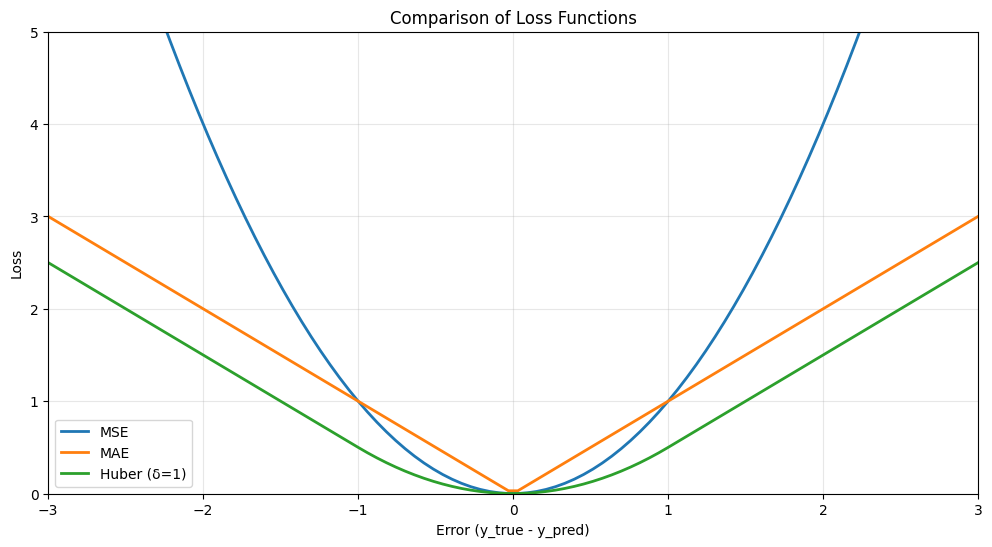

In [64]:
# Implement custom Huber loss function
def huber_fn(y_true, y_pred, threshold=1.0):
    """
    Huber loss function implementation.

    Args:
        y_true: True labels
        y_pred: Predicted values
        threshold: Threshold for switching between squared and linear loss

    Returns:
        Huber loss for each sample
    """
    error = y_true - y_pred
    is_small_error = tf.abs(error) < threshold
    squared_loss = tf.square(error) / 2
    linear_loss = threshold * tf.abs(error) - threshold**2 / 2
    return tf.where(is_small_error, squared_loss, linear_loss)

# Demonstrate the Huber loss
print("=== Huber Loss Demonstration ===")

# Create sample data
y_true = tf.constant([1., 2., 3., 4., 5.])
y_pred_close = tf.constant([1.1, 2.2, 2.9, 4.1, 4.8])  # Close predictions
y_pred_far = tf.constant([1.1, 2.2, 5.0, 8.0, 1.0])   # Some outliers

# Compare different loss functions
mse_loss_fn = tf.keras.losses.MeanSquaredError()
mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

mse_close = mse_loss_fn(y_true, y_pred_close)
mae_close = mae_loss_fn(y_true, y_pred_close)
huber_close = tf.reduce_mean(huber_fn(y_true, y_pred_close))

mse_far = mse_loss_fn(y_true, y_pred_far)
mae_far = mae_loss_fn(y_true, y_pred_far)
huber_far = tf.reduce_mean(huber_fn(y_true, y_pred_far))

print("Close predictions:")
print(f"MSE: {mse_close:.4f}, MAE: {mae_close:.4f}, Huber: {huber_close:.4f}")

print("\nPredictions with outliers:")
print(f"MSE: {mse_far:.4f}, MAE: {mae_far:.4f}, Huber: {huber_far:.4f}")

# Visualize loss functions
errors = tf.linspace(-3., 3., 100)
mse_losses = tf.square(errors)
mae_losses = tf.abs(errors)
huber_losses = [huber_fn(0., -error, threshold=1.0) for error in errors]

plt.figure(figsize=(12, 6))
plt.plot(errors, mse_losses, label='MSE', linewidth=2)
plt.plot(errors, mae_losses, label='MAE', linewidth=2)
plt.plot(errors, huber_losses, label='Huber (δ=1)', linewidth=2)
plt.xlabel('Error (y_true - y_pred)')
plt.ylabel('Loss')
plt.title('Comparison of Loss Functions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-3, 3)
plt.ylim(0, 5)
plt.show()

### 2.3 Custom Loss Class Implementation

For more complex loss functions that need to save hyperparameters, we can subclass `keras.losses.Loss`. This ensures proper serialization and deserialization of the model.

In [65]:
class HuberLoss(tf.keras.losses.Loss):
    """
    Custom Huber Loss class that can be saved with the model.

    The Huber loss is less sensitive to outliers than MSE.
    It's quadratic for small errors and linear for large errors.
    """

    def __init__(self, threshold=1.0, **kwargs):
        """
        Initialize Huber loss.

        Args:
            threshold: Point where the loss changes from quadratic to linear
            **kwargs: Additional arguments passed to parent class
        """
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        """
        Compute the Huber loss.

        Args:
            y_true: Ground truth values
            y_pred: Predicted values

        Returns:
            Huber loss for each sample
        """
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        """
        Return configuration for serialization.
        """
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

# Test the custom loss class
print("=== Custom Huber Loss Class ===")

# Create instance
huber_loss = HuberLoss(threshold=2.0)

# Test with sample data
y_true = tf.constant([[1.], [2.], [3.]])
y_pred = tf.constant([[1.5], [2.8], [0.5]])

loss_value = huber_loss(y_true, y_pred)
print(f"Huber loss values: {loss_value}")
print(f"Mean Huber loss: {tf.reduce_mean(loss_value)}")

# Test configuration saving/loading
config = huber_loss.get_config()
print(f"\nLoss configuration: {config}")

# Create new instance from config
huber_loss_2 = HuberLoss.from_config(config)
print(f"Recreated loss threshold: {huber_loss_2.threshold}")

=== Custom Huber Loss Class ===
Huber loss values: 1.1483333110809326
Mean Huber loss: 1.1483333110809326

Loss configuration: {'name': 'huber_loss_3', 'reduction': 'sum_over_batch_size', 'threshold': 2.0}
Recreated loss threshold: 2.0


## 3. Custom Metrics

### 3.1 Difference Between Losses and Metrics

**Losses vs Metrics:**
- **Losses**: Used for optimization, must be differentiable, gradients should not be zero everywhere
- **Metrics**: Used for evaluation, should be interpretable, can be non-differentiable

### 3.2 Streaming Metrics

Some metrics cannot be simply averaged across batches. For example, precision:

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

**Problem with naive averaging:**
- Batch 1: 4/5 = 80% precision
- Batch 2: 0/3 = 0% precision
- Naive average: (80% + 0%) / 2 = 40%
- Correct overall: 4/(5+3) = 50%

**Solution:** Streaming metrics maintain state across batches.

In [66]:
# Demonstrate streaming metrics
print("=== Streaming Metrics Demonstration ===")

# Create a streaming precision metric
precision = tf.keras.metrics.Precision()

# Simulate the problematic case
# Batch 1: 5 positive predictions, 4 correct (80% precision)
y_true_1 = tf.constant([0, 1, 1, 1, 0, 1, 0, 1], dtype=tf.float32) # Ensure float32 dtype
y_pred_1 = tf.constant([1, 1, 0, 1, 0, 1, 0, 1], dtype=tf.float32)  # 5 positive predictions, 4 correct

precision_1 = precision(y_true_1, y_pred_1)
print(f"After batch 1 - Precision: {precision_1:.3f}")
print(f"Variables: TP={precision.true_positives.numpy()[0]:.0f}, FP={precision.false_positives.numpy()[0]:.0f}") # Access scalar values

# Batch 2: 3 positive predictions, 0 correct (0% precision)
y_true_2 = tf.constant([0, 1, 0, 0, 1, 0, 1, 1], dtype=tf.float32) # Ensure float32 dtype
y_pred_2 = tf.constant([1, 0, 1, 1, 0, 0, 0, 0], dtype=tf.float32)  # 3 positive predictions, 0 correct

precision_2 = precision(y_true_2, y_pred_2)
print(f"After batch 2 - Precision: {precision_2:.3f}")
print(f"Variables: TP={precision.true_positives.numpy()[0]:.0f}, FP={precision.false_positives.numpy()[0]:.0f}") # Access scalar values

# Show that the result is the correct overall precision
total_tp = precision.true_positives.numpy()[0] # Extract scalar
total_fp = precision.false_positives.numpy()[0] # Extract scalar
manual_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0 # Handle division by zero
print(f"\nManual calculation: {total_tp:.0f}/{total_tp + total_fp:.0f} = {manual_precision:.3f}") # Format scalar values
print(f"Streaming metric result: {precision_2:.3f}")
print(f"Naive average would be: {(0.8 + 0.0) / 2:.3f}")

# Reset the metric
# precision.reset_states() # Call the reset_states method - Commented out due to AttributeError in TF 2.16.1
# print(f"\nAfter reset: TP={precision.true_positives.numpy()[0]:.0f}, FP={precision.false_positives.numpy()[0]:.0f}") # Access scalar values - Commented out

=== Streaming Metrics Demonstration ===
After batch 1 - Precision: 0.800
Variables: TP=4, FP=1
After batch 2 - Precision: 0.500
Variables: TP=4, FP=4

Manual calculation: 4/8 = 0.500
Streaming metric result: 0.500
Naive average would be: 0.400


In [67]:
class HuberMetric(tf.keras.metrics.Metric):
    """
    Custom streaming metric for Huber loss.

    This metric accumulates the total Huber loss and count across batches
    to compute the mean Huber loss.
    """

    def __init__(self, threshold=1.0, name='huber_metric', **kwargs):
        """
        Initialize the Huber metric.
Args:
            threshold: Threshold for Huber loss calculation
            name: Name of the metric
        """
        super().__init__(name=name, **kwargs)
        self.threshold = threshold

        # Create variables to track total loss and count
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Update metric state with a batch of data.

        Args:
            y_true: True labels
            y_pred: Predicted values
            sample_weight: Optional sample weights
        """
        # Compute Huber loss for this batch
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        huber_loss = tf.where(is_small_error, squared_loss, linear_loss)

        # Update total and count
        self.total.assign_add(tf.reduce_sum(huber_loss))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        """
        Compute the final metric result.

        Returns:
            Mean Huber loss across all batches
        """
        return self.total / self.count

    def reset_states(self):
        """
        Reset all metric variables.
        """
        self.total.assign(0.0)
        self.count.assign(0.0)

    def get_config(self):
        """
        Return configuration for serialization.
        """
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

# Test the custom streaming metric
print("=== Custom Streaming Metric Test ===")

huber_metric = HuberMetric(threshold=1.5)

# Simulate multiple batches
for i in range(3):
    y_true = tf.random.normal((10, 1))
    y_pred = y_true + tf.random.normal((10, 1), stddev=0.5)

    huber_metric.update_state(y_true, y_pred)
    print(f"After batch {i+1}: {huber_metric.result():.4f}")

print(f"Final metric variables: total={huber_metric.total.numpy():.4f}, count={huber_metric.count.numpy()}")

# Reset and verify
huber_metric.reset_states()
print(f"After reset: {huber_metric.result():.4f}")

=== Custom Streaming Metric Test ===
After batch 1: 0.0466
After batch 2: 0.0699
After batch 3: 0.0904
Final metric variables: total=2.7118, count=30.0
After reset: nan


## 4. Custom Layers

### 4.1 Theory of Neural Network Layers

A neural network layer performs a transformation:
$$\mathbf{y} = f(\mathbf{x}; \boldsymbol{\theta})$$

where:
- $\mathbf{x}$ is the input
- $\mathbf{y}$ is the output
- $\boldsymbol{\theta}$ represents the layer's parameters (weights and biases)
- $f$ is the layer's function

### 4.2 Dense Layer Mathematical Foundation

For a dense (fully connected) layer:
$$\mathbf{y} = \sigma(\mathbf{x} \mathbf{W} + \mathbf{b})$$

where:
- $\mathbf{W} \in \mathbb{R}^{n_{in} \times n_{out}}$ is the weight matrix
- $\mathbf{b} \in \mathbb{R}^{n_{out}}$ is the bias vector
- $\sigma$ is the activation function
- $n_{in}$ is the number of input features
- $n_{out}$ is the number of output features

### 4.3 Types of Custom Layers

1. **Stateless layers**: No trainable parameters (e.g., activation functions)
2. **Stateful layers**: Have trainable parameters (e.g., Dense, Conv2D)
3. **Dynamic layers**: Behavior changes during training vs inference

In [68]:
# Simple stateless custom layer using Lambda
print("=== Stateless Custom Layer ===")

# Create an exponential layer
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

# Test the layer
test_input = tf.constant([[1.0, 2.0, 3.0]])
output = exponential_layer(test_input)
print(f"Input: {test_input}")
print(f"Exponential output: {output}")
print(f"Manual verification: {tf.exp(test_input)}")

# Alternative: direct function usage
def exponential_activation(x):
    """Custom exponential activation function."""
    return tf.exp(x)

# Create a simple model with custom activation
model_with_custom_activation = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(3,)),
    tf.keras.layers.Lambda(exponential_activation),
    tf.keras.layers.Dense(1)
])

print(f"\nModel with custom activation:")
print(model_with_custom_activation.summary())

=== Stateless Custom Layer ===
Input: [[1. 2. 3.]]
Exponential output: [[ 2.7182817  7.389056  20.085537 ]]
Manual verification: [[ 2.7182817  7.389056  20.085537 ]]

Model with custom activation:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26 (104.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
class MyDense(tf.keras.layers.Layer):
    """
    Custom implementation of a Dense layer.

    This demonstrates how to create stateful layers with trainable parameters.
    Mathematical operation: output = activation(input @ kernel + bias)
    """

    def __init__(self, units, activation=None, **kwargs):
        """
        Initialize the custom dense layer.

        Args:
            units: Number of output units
            activation: Activation function
            **kwargs: Additional arguments for parent class
        """
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        """
        Create the layer's weights.

        Args:
            batch_input_shape: Shape of input including batch dimension
        """
        # Kernel weight matrix: [input_dim, units]
        self.kernel = self.add_weight(
            name="kernel",
            shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal",  # Xavier initialization
            trainable=True
        )

        # Bias vector: [units]
        self.bias = self.add_weight(
            name="bias",
            shape=[self.units],
            initializer="zeros",
            trainable=True
        )

        # Must call parent build at the end
        super().build(batch_input_shape)

    def call(self, inputs):
        """
        Forward pass computation.

        Args:
            inputs: Input tensor

        Returns:
            Output tensor after linear transformation and activation
        """
        # Linear transformation: X @ W + b
        linear_output = tf.matmul(inputs, self.kernel) + self.bias

        # Apply activation function
        return self.activation(linear_output)

    def compute_output_shape(self, batch_input_shape):
        """
        Compute output shape given input shape.

        Args:
            batch_input_shape: Input shape including batch dimension

        Returns:
            Output shape
        """
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        """
        Return layer configuration for serialization.
        """
        base_config = super().get_config()
        return {
            **base_config,
            "units": self.units,
            "activation": tf.keras.activations.serialize(self.activation)
        }

# Test the custom Dense layer
print("=== Custom Dense Layer Test ===")

# Create test data
X_test = tf.random.normal((5, 3))  # 5 samples, 3 features
print(f"Input shape: {X_test.shape}")

# Create custom layer
custom_dense = MyDense(units=4, activation='relu')

# Forward pass
output = custom_dense(X_test)
print(f"Output shape: {output.shape}")
print(f"Output:\n{output}")

# Check weights
print(f"\nKernel shape: {custom_dense.kernel.shape}")
print(f"Bias shape: {custom_dense.bias.shape}")
print(f"Number of trainable variables: {len(custom_dense.trainable_variables)}")

# Compare with standard Keras Dense layer
keras_dense = tf.keras.layers.Dense(units=4, activation='relu')
keras_output = keras_dense(X_test)
print(f"\nKeras Dense output shape: {keras_output.shape}")
print(f"Shapes match: {output.shape == keras_output.shape}")

=== Custom Dense Layer Test ===
Input shape: (5, 3)
Output shape: (5, 4)
Output:
[[0.         0.         0.06277205 0.07777292]
 [0.         1.1126729  0.         0.        ]
 [0.7243442  0.         0.         0.6176762 ]
 [0.7547236  0.7969121  0.         0.        ]
 [0.19377469 0.         0.05350849 0.3102726 ]]

Kernel shape: (3, 4)
Bias shape: (4,)
Number of trainable variables: 2

Keras Dense output shape: (5, 4)
Shapes match: True


In [70]:
class MyMultiLayer(tf.keras.layers.Layer):
    """
    Custom layer with multiple inputs and outputs.

    This layer takes two inputs and produces three outputs:
    - Sum of inputs
    - Element-wise product of inputs
    - Element-wise division of first by second input
    """

    def call(self, inputs):
        """
        Forward pass with multiple inputs and outputs.

        Args:
            inputs: Tuple of (input1, input2)

        Returns:
            List of [sum, product, division] outputs
        """
        X1, X2 = inputs
        return [
            X1 + X2,                    # Sum
            X1 * X2,                    # Element-wise product
            X1 / (X2 + 1e-7)           # Division with small epsilon
        ]

    def compute_output_shape(self, batch_input_shape):
        """
        Compute output shapes for multiple outputs.

        Args:
            batch_input_shape: Tuple of input shapes

        Returns:
            List of output shapes
        """
        b1, b2 = batch_input_shape
        # All outputs have the same shape as the first input
        return [b1, b1, b1]

# Test multi-input/output layer
print("=== Multi-Input/Output Layer Test ===")

# Create test inputs
input1 = tf.constant([[1., 2., 3.], [4., 5., 6.]])
input2 = tf.constant([[2., 1., 2.], [1., 3., 2.]])

print(f"Input 1:\n{input1}")
print(f"Input 2:\n{input2}")

# Apply custom layer
multi_layer = MyMultiLayer()
outputs = multi_layer([input1, input2])

print(f"\nOutput 1 (Sum):\n{outputs[0]}")
print(f"Output 2 (Product):\n{outputs[1]}")
print(f"Output 3 (Division):\n{outputs[2]}")

# Verify calculations manually
print(f"\nManual verification:")
print(f"Sum: {input1 + input2}")
print(f"Product: {input1 * input2}")
print(f"Division: {input1 / (input2 + 1e-7)}")

=== Multi-Input/Output Layer Test ===
Input 1:
[[1. 2. 3.]
 [4. 5. 6.]]
Input 2:
[[2. 1. 2.]
 [1. 3. 2.]]

Output 1 (Sum):
[[3. 3. 5.]
 [5. 8. 8.]]
Output 2 (Product):
[[ 2.  2.  6.]
 [ 4. 15. 12.]]
Output 3 (Division):
[[0.5       1.9999998 1.5      ]
 [3.9999995 1.6666666 3.       ]]

Manual verification:
Sum: [[3. 3. 5.]
 [5. 8. 8.]]
Product: [[ 2.  2.  6.]
 [ 4. 15. 12.]]
Division: [[0.5       1.9999998 1.5      ]
 [3.9999995 1.6666666 3.       ]]


In [71]:
class MyGaussianNoise(tf.keras.layers.Layer):
    """
    Custom Gaussian noise layer for regularization.

    Adds Gaussian noise during training but does nothing during inference.
    This helps prevent overfitting by adding stochasticity to the inputs.
    """

    def __init__(self, stddev, **kwargs):
        """
        Initialize Gaussian noise layer.

        Args:
            stddev: Standard deviation of the noise
            **kwargs: Additional arguments for parent class
        """
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        """
        Forward pass with conditional noise addition.

        Args:
            inputs: Input tensor
            training: Boolean indicating training vs inference mode

        Returns:
            Noisy inputs during training, clean inputs during inference
        """
        if training:
            # Add Gaussian noise during training
            noise = tf.random.normal(
                shape=tf.shape(inputs),
                stddev=self.stddev,
                dtype=inputs.dtype
            )
            return inputs + noise
        else:
            # Return inputs unchanged during inference
            return inputs

    def compute_output_shape(self, batch_input_shape):
        """
        Output shape is the same as input shape.
        """
        return batch_input_shape

    def get_config(self):
        """
        Return configuration for serialization.
        """
        base_config = super().get_config()
        return {**base_config, "stddev": self.stddev}

# Test Gaussian noise layer
print("=== Gaussian Noise Layer Test ===")

# Create test input
test_input = tf.constant([[1., 2., 3.], [4., 5., 6.]])
print(f"Original input:\n{test_input}")

# Create noise layer
noise_layer = MyGaussianNoise(stddev=0.1)

# Test in training mode
noisy_output = noise_layer(test_input, training=True)
print(f"\nWith noise (training=True):\n{noisy_output}")
print(f"Noise added: {noisy_output - test_input}")

# Test in inference mode
clean_output = noise_layer(test_input, training=False)
print(f"\nWithout noise (training=False):\n{clean_output}")
print(f"Same as input: {tf.reduce_all(tf.equal(clean_output, test_input))}")

# Test multiple calls in training mode (should produce different noise)
noisy_output_2 = noise_layer(test_input, training=True)
print(f"\nSecond noisy output:\n{noisy_output_2}")
print(f"Different noise: {not tf.reduce_all(tf.equal(noisy_output, noisy_output_2))}")

=== Gaussian Noise Layer Test ===
Original input:
[[1. 2. 3.]
 [4. 5. 6.]]

With noise (training=True):
[[1.1144209 1.8391021 2.8652778]
 [3.9383066 5.0845466 6.015746 ]]
Noise added: [[ 0.11442089 -0.16089785 -0.13472223]
 [-0.06169343  0.08454657  0.01574612]]

Without noise (training=False):
[[1. 2. 3.]
 [4. 5. 6.]]
Same as input: True

Second noisy output:
[[0.8411654 2.080656  2.9700024]
 [3.9438875 4.994624  6.0803585]]
Different noise: True


## 5. Custom Models

### 5.1 Model vs Layer Distinction

**Models** provide additional functionality beyond layers:
- `compile()`, `fit()`, `evaluate()`, `predict()` methods
- `save()` and loading capabilities
- `get_layers()` method
- Model cloning support

**Design Principle:**
- **Layers**: Internal components and reusable blocks
- **Models**: Complete architectures ready for training

### 5.2 Residual Connections Theory

Residual connections help with:
1. **Gradient flow**: Prevent vanishing gradients
2. **Identity mapping**: Allow layers to learn deviations from identity
3. **Deep networks**: Enable training of very deep architectures

**Mathematical formulation:**
$$\mathbf{y} = \mathcal{F}(\mathbf{x}) + \mathbf{x}$$

where $\mathcal{F}(\mathbf{x})$ is the residual function and $\mathbf{x}$ is the identity shortcut.

In [72]:
class ResidualBlock(tf.keras.layers.Layer):
    """
    Residual block implementation.

    A residual block consists of multiple layers with a skip connection
    that adds the input to the output: output = F(x) + x

    This helps with gradient flow and enables training deeper networks.
    """

    def __init__(self, n_layers, n_neurons, **kwargs):
        """
        Initialize residual block.

        Args:
            n_layers: Number of hidden layers in the block
            n_neurons: Number of neurons per layer
            **kwargs: Additional arguments for parent class
        """
        super().__init__(**kwargs)

        # Create the hidden layers
        self.hidden = [
            tf.keras.layers.Dense(
                n_neurons,
                activation="elu",
                kernel_initializer="he_normal"
            )
            for _ in range(n_layers)
        ]

    def call(self, inputs):
        """
        Forward pass through residual block.

        Args:
            inputs: Input tensor

        Returns:
            Output tensor with residual connection: F(x) + x
        """
        Z = inputs

        # Pass through all hidden layers
        for layer in self.hidden:
            Z = layer(Z)

        # Add residual connection (skip connection)
        return inputs + Z

# Test residual block
print("=== Residual Block Test ===")

# Create test input
test_input = tf.random.normal((4, 30))  # Batch of 4, 30 features
print(f"Input shape: {test_input.shape}")

# Create residual block
residual_block = ResidualBlock(n_layers=2, n_neurons=30)

# Forward pass
output = residual_block(test_input)
print(f"Output shape: {output.shape}")

# Verify residual connection
# The output should be different from input due to the learned transformation
print(f"Output equals input: {tf.reduce_all(tf.equal(output, test_input))}")
print(f"Mean absolute difference: {tf.reduce_mean(tf.abs(output - test_input)):.4f}")

# Check that block has trainable parameters
print(f"Number of trainable variables: {len(residual_block.trainable_variables)}")
print(f"Total parameters: {sum(tf.size(var) for var in residual_block.trainable_variables)}")

=== Residual Block Test ===
Input shape: (4, 30)
Output shape: (4, 30)
Output equals input: False
Mean absolute difference: 0.9256
Number of trainable variables: 4
Total parameters: 1860


In [73]:
class ResidualRegressor(tf.keras.Model):
    """
    Custom model with residual connections.

    Architecture:
    Input -> Dense -> ResidualBlock (4x) -> ResidualBlock -> Dense -> Output

    This model demonstrates:
    - Custom model architecture
    - Reusable residual blocks
    - Loop structures in model definition
    """

    def __init__(self, output_dim, **kwargs):
        """
        Initialize the residual regressor.

        Args:
            output_dim: Number of output units
            **kwargs: Additional arguments for parent class
        """
        super().__init__(**kwargs)

        # Define layers
        self.hidden1 = tf.keras.layers.Dense(
            30, activation="elu", kernel_initializer="he_normal"
        )
        self.block1 = ResidualBlock(2, 30)  # First residual block
        self.block2 = ResidualBlock(2, 30)  # Second residual block
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        """
        Forward pass through the model.

        Args:
            inputs: Input tensor

        Returns:
            Model predictions
        """
        # Initial transformation
        Z = self.hidden1(inputs)

        # Pass through first block multiple times
        for _ in range(1 + 3):  # 4 times total
            Z = self.block1(Z)

        # Pass through second block
        Z = self.block2(Z)

        # Final output
        return self.out(Z)

    def get_config(self):
        """
        Return model configuration for serialization.
        """
        base_config = super().get_config()
        return {**base_config, "output_dim": self.out.units}

# Test custom model
print("=== Custom Residual Model Test ===")

# Create sample data for testing
X_sample = tf.random.normal((10, 8))  # 10 samples, 8 features
print(f"Input shape: {X_sample.shape}")

# Create model
model = ResidualRegressor(output_dim=1)

# Forward pass
predictions = model(X_sample)
print(f"Predictions shape: {predictions.shape}")
print(f"Sample predictions: {predictions[:5].numpy().flatten()}")

# Model summary (build the model first)
model.build(input_shape=(None, 8))
print(f"\nModel summary:")
print(f"Total trainable parameters: {model.count_params()}")

# Check model structure
print(f"\nModel layers:")
for i, layer in enumerate(model.layers):
    print(f" {i}: {layer.name} - {type(layer).__name__}")

=== Custom Residual Model Test ===
Input shape: (10, 8)
Predictions shape: (10, 1)
Sample predictions: [ 5.7834334 -8.270904  18.611135   3.4524736 10.936957 ]

Model summary:
Total trainable parameters: 4021

Model layers:
 0: dense_47 - Dense
 1: residual_block_7 - ResidualBlock
 2: residual_block_8 - ResidualBlock
 3: dense_52 - Dense


### 5.3 Models with Internal Losses

Sometimes we need losses based on model internals for regularization or auxiliary tasks. The reconstruction loss is an example:

$\mathcal{L}_{reconstruction} = \frac{1}{n} \sum_{i=1}^{n} ||\mathbf{x}_i - \hat{\mathbf{x}}_i||^2$

where $\hat{\mathbf{x}}_i$ is the reconstructed input from hidden representations.

**Benefits:**
- Encourages information preservation through hidden layers
- Acts as regularization
- Can improve generalization

In [74]:
class ReconstructingRegressor(tf.keras.Model):
    """
    Model with auxiliary reconstruction loss.

    This model includes a reconstruction branch that tries to
    reconstruct the input from the hidden representation.
    The reconstruction loss is added to the main loss.
    """

    def __init__(self, output_dim, **kwargs):
        """
        Initialize the reconstructing regressor.

        Args:
            output_dim: Number of output units for main task
            **kwargs: Additional arguments for parent class
        """
        super().__init__(**kwargs)

        # Main network layers
        self.hidden = [
            tf.keras.layers.Dense(
                30, activation="selu", kernel_initializer="lecun_normal"
            )
            for _ in range(5)
        ]

        # Main output layer
        self.out = tf.keras.layers.Dense(output_dim)

    def build(self, batch_input_shape):
        """
        Create the reconstruction layer based on input shape.

        Args:
            batch_input_shape: Shape of input including batch dimension
        """
        n_inputs = batch_input_shape[-1]

        # Reconstruction layer (same size as input)
        self.reconstruct = tf.keras.layers.Dense(n_inputs)

        super().build(batch_input_shape)

    def call(self, inputs):
        """
        Forward pass with reconstruction loss.

        Args:
            inputs: Input tensor

        Returns:
            Main task predictions
        """
        Z = inputs

        # Pass through hidden layers
        for layer in self.hidden:
            Z = layer(Z)

        # Reconstruction from hidden representation
        reconstruction = self.reconstruct(Z)

        # Compute reconstruction loss
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))

        # Add reconstruction loss (scaled down)
        self.add_loss(0.05 * recon_loss)

        # Return main task output
        return self.out(Z)

# Test reconstructing model
print("=== Reconstructing Model Test ===")

# Create sample data
X_sample = tf.random.normal((8, 5))  # 8 samples, 5 features
print(f"Input shape: {X_sample.shape}")

# Create model
recon_model = ReconstructingRegressor(output_dim=1)

# Forward pass
output = recon_model(X_sample)
print(f"Output shape: {output.shape}")

# Check losses
print(f"Model losses: {[loss.numpy() for loss in recon_model.losses]}")
print(f"Total additional losses: {len(recon_model.losses)}")

# Test with different input
X_sample2 = tf.random.normal((8, 5))
output2 = recon_model(X_sample2)
print(f"New losses after second forward pass: {[loss.numpy() for loss in recon_model.losses]}")

=== Reconstructing Model Test ===
Input shape: (8, 5)
Output shape: (8, 1)
Model losses: [0.15287887]
Total additional losses: 1
New losses after second forward pass: [0.13783038]


## 6. Automatic Differentiation (Autodiff)

### 6.1 Mathematical Foundation of Autodiff

Automatic differentiation computes exact derivatives efficiently using the chain rule:

For a composite function $f(g(x))$:
$\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$

### 6.2 Forward vs Reverse Mode

**Forward Mode (Forward Accumulation):**
- Computes derivatives of all intermediate variables with respect to input
- Efficient when number of inputs < number of outputs
- Complexity: O(n) for n inputs

**Reverse Mode (Backpropagation):**
- Computes derivatives of output with respect to all intermediate variables
- Efficient when number of outputs < number of inputs
- Complexity: O(m) for m outputs
- Preferred for neural networks (many parameters, few outputs)

### 6.3 Gradient Computation Example

For function $f(w_1, w_2) = 3w_1^2 + 2w_1w_2$:

Analytical derivatives:
- $\frac{\partial f}{\partial w_1} = 6w_1 + 2w_2$
- $\frac{\partial f}{\partial w_2} = 2w_1$

At point $(w_1, w_2) = (5, 3)$:
- $\frac{\partial f}{\partial w_1} = 6(5) + 2(3) = 36$
- $\frac{\partial f}{\partial w_2} = 2(5) = 10$

In [75]:
def f(w1, w2):
    """
    Example function for gradient computation.
    f(w1, w2) = 3*w1^2 + 2*w1*w2
    """
    return 3 * w1 ** 2 + 2 * w1 * w2

print("=== Automatic Differentiation Demonstration ===")

# Compare numerical approximation vs autodiff
w1, w2 = 5, 3
eps = 1e-6

# Numerical approximation (finite differences)
print("Numerical Approximation:")
df_dw1_numerical = (f(w1 + eps, w2) - f(w1, w2)) / eps
df_dw2_numerical = (f(w1, w2 + eps) - f(w1, w2)) / eps
print(f"∂f/∂w1 ≈ {df_dw1_numerical:.6f}")
print(f"∂f/∂w2 ≈ {df_dw2_numerical:.6f}")

# Analytical solution
print("\nAnalytical Solution:")
df_dw1_analytical = 6 * w1 + 2 * w2
df_dw2_analytical = 2 * w1
print(f"∂f/∂w1 = {df_dw1_analytical}")
print(f"∂f/∂w2 = {df_dw2_analytical}")

# TensorFlow automatic differentiation
print("\nTensorFlow Autodiff:")
w1_tf, w2_tf = tf.Variable(5.), tf.Variable(3.)

with tf.GradientTape() as tape:
    z = f(w1_tf, w2_tf)

gradients = tape.gradient(z, [w1_tf, w2_tf])
print(f"∂f/∂w1 = {gradients[0].numpy()}")
print(f"∂f/∂w2 = {gradients[1].numpy()}")

# Verify all methods give same result
print("\nVerification:")
print(f"All methods agree: {np.allclose([df_dw1_numerical, df_dw2_numerical], [df_dw1_analytical, df_dw2_analytical], atol=1e-5)}")
print(f"Autodiff matches analytical: {np.allclose([gradients[0].numpy(), gradients[1].numpy()], [df_dw1_analytical, df_dw2_analytical])}")

=== Automatic Differentiation Demonstration ===
Numerical Approximation:
∂f/∂w1 ≈ 36.000003
∂f/∂w2 ≈ 10.000000

Analytical Solution:
∂f/∂w1 = 36
∂f/∂w2 = 10

TensorFlow Autodiff:
∂f/∂w1 = 36.0
∂f/∂w2 = 10.0

Verification:
All methods agree: True
Autodiff matches analytical: True


In [76]:
print("=== GradientTape Advanced Features ===")

# 1. Persistent tape for multiple gradient calls
print("1. Persistent Tape:")
w1, w2 = tf.Variable(5.), tf.Variable(3.)

with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

# Multiple gradient calls
dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2)
print(f"∂z/∂w1 = {dz_dw1.numpy()}")
print(f"∂z/∂w2 = {dz_dw2.numpy()}")

# Clean up persistent tape
del tape

# 2. Watching non-variable tensors
print("\n2. Watching Constants:")
c1, c2 = tf.constant(5.), tf.constant(3.)

with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
print(f"Gradients w.r.t. constants: {[g.numpy() for g in gradients]}")

# 3. Higher-order derivatives
print("\n3. Second-Order Derivatives:")
x = tf.Variable(2.0)

with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        y = x ** 3  # f(x) = x^3

    # First derivative: f'(x) = 3x^2
    dy_dx = inner_tape.gradient(y, x)

# Second derivative: f''(x) = 6x
d2y_dx2 = outer_tape.gradient(dy_dx, x)

print(f"f(x) = x³ at x = 2")
print(f"f'(2) = 3(2)² = {dy_dx.numpy()} (expected: 12)")
print(f"f''(2) = 6(2) = {d2y_dx2.numpy()} (expected: 12)")

# 4. Stopping gradients
print("\n4. Gradient Stopping:")
def f_with_stop_gradient(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

w1, w2 = tf.Variable(5.), tf.Variable(3.)

with tf.GradientTape() as tape:
    z = f_with_stop_gradient(w1, w2)

gradients = tape.gradient(z, [w1, w2])
print(f"With stop_gradient:")
print(f"∂f/∂w1 = {gradients[0].numpy()} (expected: 30, since 6*5 + 0)")
print(f"∂f/∂w2 = {gradients[1]} (expected: None, gradient stopped)")

=== GradientTape Advanced Features ===
1. Persistent Tape:
∂z/∂w1 = 36.0
∂z/∂w2 = 10.0

2. Watching Constants:
Gradients w.r.t. constants: [36.0, 10.0]

3. Second-Order Derivatives:
f(x) = x³ at x = 2
f'(2) = 3(2)² = 12.0 (expected: 12)
f''(2) = 6(2) = 12.0 (expected: 12)

4. Gradient Stopping:
With stop_gradient:
∂f/∂w1 = 30.0 (expected: 30, since 6*5 + 0)
∂f/∂w2 = None (expected: None, gradient stopped)


In [77]:
# Custom gradient for numerical stability
@tf.custom_gradient
def my_better_softplus(z):
    """
    Numerically stable softplus with custom gradient.

    The standard softplus: softplus(x) = log(1 + exp(x))
    Its derivative: d/dx softplus(x) = exp(x) / (1 + exp(x)) = sigmoid(x)

    For large x, this can cause numerical issues, so we use a stable implementation.
    """
    exp_z = tf.exp(z)

    def softplus_gradient(upstream_grad):
        # Stable gradient computation: 1 / (1 + exp(-z)) = sigmoid(z)
        return upstream_grad / (1 + 1 / exp_z)

    # Return function value and gradient function
    return tf.math.log(exp_z + 1), softplus_gradient

print("=== Custom Gradient Demonstration ===")

# Compare standard softplus vs custom implementation
def standard_softplus(z):
    return tf.math.log(tf.exp(z) + 1)

# Test with regular values
x_normal = tf.Variable([1.0, 2.0, 3.0])
print("Normal values:")

with tf.GradientTape() as tape:
    y_standard = standard_softplus(x_normal)
grad_standard = tape.gradient(y_standard, x_normal)

with tf.GradientTape() as tape:
    y_custom = my_better_softplus(x_normal)
grad_custom = tape.gradient(y_custom, x_normal)

print(f"Standard gradients: {grad_standard.numpy()}")
print(f"Custom gradients: {grad_custom.numpy()}")
print(f"Values match: {np.allclose(grad_standard.numpy(), grad_custom.numpy())}")

# Test with large values (where standard implementation might fail)
x_large = tf.Variable([100.0])
print("\nLarge values:")

with tf.GradientTape() as tape:
    y_standard = standard_softplus(x_large)
grad_standard = tape.gradient(y_standard, x_large)

with tf.GradientTape() as tape:
    y_custom = my_better_softplus(x_large)
grad_custom = tape.gradient(y_custom, x_large)

print(f"Standard gradient: {grad_standard.numpy()}")
print(f"Custom gradient: {grad_custom.numpy()}")
print(f"Standard has NaN: {tf.reduce_any(tf.math.is_nan(grad_standard))}")
print(f"Custom has NaN: {tf.reduce_any(tf.math.is_nan(grad_custom))}")

=== Custom Gradient Demonstration ===
Normal values:
Standard gradients: [0.7310586  0.8807971  0.95257413]
Custom gradients: [0.7310586  0.880797   0.95257413]
Values match: True

Large values:
Standard gradient: [nan]
Custom gradient: [1.]
Standard has NaN: True
Custom has NaN: False


## 7. Custom Training Loops

### 7.1 When to Use Custom Training Loops

Custom training loops are needed when:
1. **Multiple optimizers**: Different parts of the network need different optimizers
2. **Complex gradient processing**: Custom gradient clipping or transformations
3. **Specialized training procedures**: Custom schedules, constraints, or algorithms
4. **Research**: Full control over the training process

### 7.2 Mathematical Foundation

The training loop implements gradient descent:

1. **Forward pass**: $\hat{\mathbf{y}} = f(\mathbf{x}; \boldsymbol{\theta})$
2. **Loss computation**: $\mathcal{L} = \ell(\mathbf{y}, \hat{\mathbf{y}}) + \lambda R(\boldsymbol{\theta})$
3. **Gradient computation**: $\mathbf{g} = \nabla_{\boldsymbol{\theta}} \mathcal{L}$
4. **Parameter update**: $\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \eta \mathbf{g}$

where:
- $\ell$ is the main loss function
- $R(\boldsymbol{\theta})$ is regularization
- $\lambda$ is the regularization coefficient
- $\eta$ is the learning rate

In [78]:
# Prepare data for custom training loop demonstration
print("=== Data Preparation ===")

# Load California housing dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert to TensorFlow format
X_train_scaled = tf.constant(X_train_scaled, dtype=tf.float32)
y_train = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32)
X_valid_scaled = tf.constant(X_valid_scaled, dtype=tf.float32)
y_valid = tf.constant(y_valid.reshape(-1, 1), dtype=tf.float32)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation set shape: {X_valid_scaled.shape}")
print(f"Feature names: {housing.feature_names}")
print(f"Target statistics: mean={tf.reduce_mean(y_train):.3f}, std={tf.math.reduce_std(y_train):.3f}")

=== Data Preparation ===
Training set shape: (13209, 8)
Training labels shape: (13209, 1)
Validation set shape: (3303, 8)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target statistics: mean=2.067, std=1.151


In [79]:
# Utility functions for custom training loop
def random_batch(X, y, batch_size=32):
    """
    Sample a random batch from the dataset.

    Args:
        X: Input features
        y: Target values
        batch_size: Size of the batch

    Returns:
        Tuple of (X_batch, y_batch)
    """
    idx = tf.random.uniform([batch_size], 0, tf.shape(X)[0], dtype=tf.int32)
    return tf.gather(X, idx), tf.gather(y, idx)

def print_status_bar(iteration, total, loss, metrics=None):
    """
    Print training progress bar.

    Args:
        iteration: Current iteration
        total: Total iterations
        loss: Current loss value
        metrics: List of metric objects
    """
    metrics = metrics or []
    if hasattr(loss, 'result'):
        loss_val = loss.result()
    else:
        loss_val = loss

    bar_length = 30
    progress = iteration / total
    filled = int(bar_length * progress)
    bar = '=' * filled + '-' * (bar_length - filled)

    metrics_str = " - ".join([
        f"{m.name}: {m.result():.4f}" for m in metrics
    ])

    end_char = "\n" if iteration >= total else "\r"

    print(f"\r{iteration}/{total} [{bar}] - loss: {loss_val:.4f}"
          + (f" - {metrics_str}" if metrics_str else ""),
          end=end_char)

# Test utility functions
print("=== Utility Functions Test ===")

# Test random batch sampling
X_batch, y_batch = random_batch(X_train_scaled, y_train, batch_size=5)
print(f"Random batch X shape: {X_batch.shape}")
print(f"Random batch y shape: {y_batch.shape}")
print(f"Sample X values: {X_batch[0].numpy()}")
print(f"Sample y value: {y_batch[0].numpy()}")

# Test status bar
print("\nStatus bar test:")
for i in range(0, 101, 20):
    print_status_bar(i, 100, i * 0.01)
time.sleep(0.1)  # Simulate processing time

=== Utility Functions Test ===
Random batch X shape: (5, 8)
Random batch y shape: (5, 1)
Sample X values: [ 0.23577133  0.19324304  0.49314213 -0.11764727 -0.35695305  0.04960413
 -0.71087915  0.8644089 ]
Sample y value: [2.33]

Status bar test:
100/100 [==============================] - loss: 1.0000


=== Custom Training Loop Implementation ===
Training configuration:
  Epochs: 5
  Batch size: 32
  Steps per epoch: 412
  Optimizer: Nadam
  Learning rate: 0.009999999776482582

Starting custom training loop...

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 - val_loss: 0.6240 - val_mae: 0.5374

Epoch 2/5
 - val_loss: 0.5098 - val_mae: 0.5234

Epoch 3/5
 - val_loss: 0.9591 - val_mae: 0.5183

Epoch 4/5
 - val_loss: 0.4893 - val_mae: 0.5079

Epoch 5/5
 - val_loss: 0.4951 - val_mae: 0.4908

Training completed!


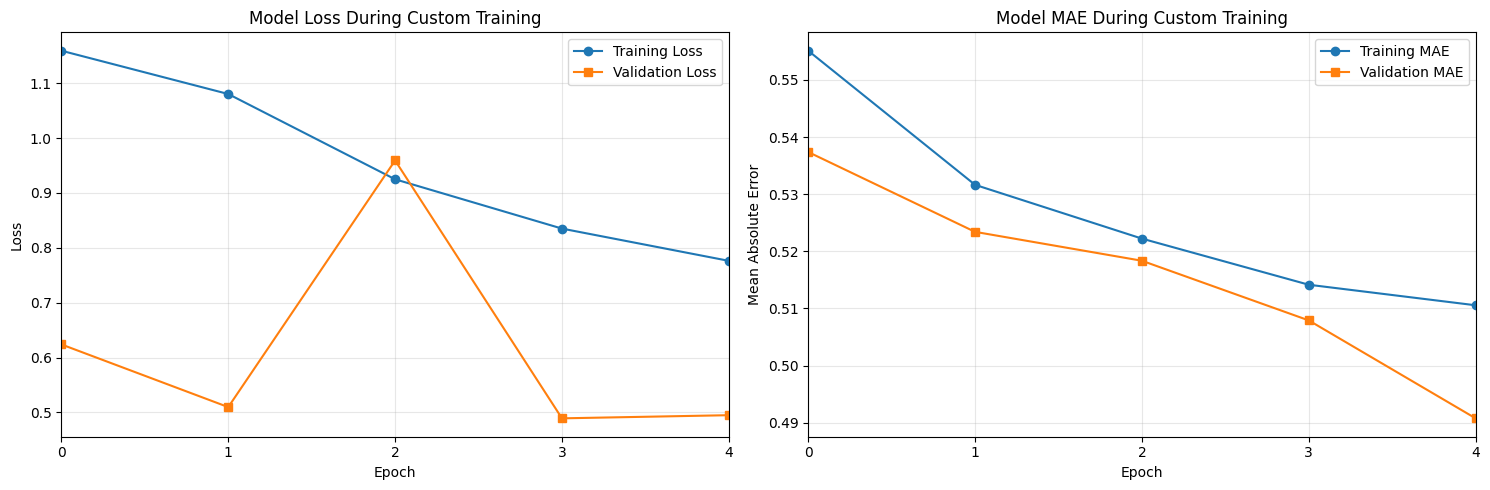


Final Results:
Training Loss: 0.7762
Validation Loss: 0.4951
Training MAE: 0.5106
Validation MAE: 0.4908


In [80]:
# Implement complete custom training loop
print("=== Custom Training Loop Implementation ===")

# Create model for custom training
l2_reg = tf.keras.regularizers.l2(0.01)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                         kernel_regularizer=l2_reg, input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

# Training hyperparameters
n_epochs = 5
batch_size = 32
n_steps = len(X_train_scaled) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

# Metrics
mean_loss = tf.keras.metrics.Mean(name='train_loss')
metrics = [tf.keras.metrics.MeanAbsoluteError(name='train_mae')]

print(f"Training configuration:")
print(f"  Epochs: {n_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Steps per epoch: {n_steps}")
print(f"  Optimizer: {optimizer.__class__.__name__}")
print(f"  Learning rate: {optimizer.learning_rate.numpy()}")

# Training loop
print("\nStarting custom training loop...")
training_history = {'loss': [], 'mae': [], 'val_loss': [], 'val_mae': []}

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}/{n_epochs}")

    # Reset metrics for this epoch
    # mean_loss.reset_states() # Commented out due to AttributeError in TF 2.16.1
    # for metric in metrics: # Commented out due to AttributeError in TF 2.16.1
    #     metric.reset_states() # Commented out due to AttributeError in TF 2.16.1

    # Training steps
    for step in range(1, n_steps + 1):
        # Sample a batch
        X_batch, y_batch = random_batch(X_train_scaled, y_train, batch_size)

        # Forward pass and gradient computation
        with tf.GradientTape() as tape:
            # Predictions
            y_pred = model(X_batch, training=True)

            # Main loss
            main_loss = loss_fn(y_batch, y_pred) # Use the instantiated loss object

            # Total loss (main + regularization)
            total_loss = tf.add_n([tf.reduce_mean(main_loss)] + model.losses) # Reduce mean for batch loss

        # Compute gradients
        gradients = tape.gradient(total_loss, model.trainable_variables)

        # Apply gradients
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Update metrics
        mean_loss.update_state(total_loss)
        for metric in metrics:
            metric.update_state(y_batch, y_pred)

        # Print progress
        if step % 50 == 0 or step == n_steps:
            print_status_bar(step * batch_size, len(X_train_scaled), mean_loss, metrics)

    # Validation evaluation
    val_loss = tf.keras.metrics.Mean()
    val_mae = tf.keras.metrics.MeanAbsoluteError()

    # Evaluate on validation set
    val_predictions = model(X_valid_scaled, training=False)
    val_loss_value = tf.reduce_mean(loss_fn(y_valid, val_predictions)) # Use the instantiated loss object and reduce mean
    val_loss.update_state(val_loss_value)
    val_mae.update_state(y_valid, val_predictions)

    # Store history
    training_history['loss'].append(mean_loss.result().numpy())
    training_history['mae'].append(metrics[0].result().numpy())
    training_history['val_loss'].append(val_loss.result().numpy())
    training_history['val_mae'].append(val_mae.result().numpy())

    print(f" - val_loss: {val_loss.result():.4f} - val_mae: {val_mae.result():.4f}")

print("\nTraining completed!")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(training_history['loss'], label='Training Loss', marker='o')
ax1.plot(training_history['val_loss'], label='Validation Loss', marker='s')
ax1.set_title('Model Loss During Custom Training')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, n_epochs -1) # Adjusted x-limit
ax1.set_xticks(range(n_epochs)) # Ensure ticks are at epoch numbers

# MAE plot
ax2.plot(training_history['mae'], label='Training MAE', marker='o')
ax2.plot(training_history['val_mae'], label='Validation MAE', marker='s')
ax2.set_title('Model MAE During Custom Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, n_epochs - 1) # Adjusted x-limit
ax2.set_xticks(range(n_epochs)) # Ensure ticks are at epoch numbers


plt.tight_layout()
plt.show()

# Final evaluation
print(f"\nFinal Results:")
print(f"Training Loss: {training_history['loss'][-1]:.4f}")
print(f"Validation Loss: {training_history['val_loss'][-1]:.4f}")
print(f"Training MAE: {training_history['mae'][-1]:.4f}")
print(f"Validation MAE: {training_history['val_mae'][-1]:.4f}")

## 8. TensorFlow Functions and Graph Optimization

### 8.1 Theory of Computation Graphs

TensorFlow Functions convert Python functions into computation graphs for optimization:

**Benefits of Graphs:**
1. **Optimization**: Prune unused nodes, simplify expressions
2. **Parallelization**: Run independent operations in parallel
3. **Portability**: Deploy across different platforms
4. **Memory efficiency**: Optimize memory usage

### 8.2 AutoGraph Process

**AutoGraph Transformation:**
1. **Source code analysis**: Parse Python control flow
2. **Control flow conversion**: Replace with TensorFlow operations
   - `for` loops → `tf.while_loop()`
   - `if` statements → `tf.cond()`
   - `break`/`continue` → graph control flow

**Tracing Process:**
1. **Symbolic execution**: Run with symbolic tensors (shape + dtype, no values)
2. **Graph construction**: Build computation graph
3. **Optimization**: Apply graph-level optimizations
4. **Caching**: Cache graphs by input signature

### 8.3 Function Polymorphism

TensorFlow Functions create separate graphs for each unique input signature:
- **Tensor arguments**: One graph per (shape, dtype) combination
- **Python arguments**: One graph per distinct value

**Performance Implications:**
- Many distinct Python values → many graphs → memory overhead
- Use Python arguments for hyperparameters only

In [81]:
# Basic TensorFlow Function demonstration
print("=== TensorFlow Functions Basic Example ===")

def cube(x):
    """
    Simple function to compute cube of input.
    """
    return x ** 3

# Convert to TensorFlow Function
tf_cube = tf.function(cube)

print(f"Original function type: {type(cube)}")
print(f"TF Function type: {type(tf_cube)}")

# Test with different inputs
print("\nFunction calls:")
print(f"Python function - cube(2): {cube(2)}")
print(f"TF Function - tf_cube(2): {tf_cube(2)}")
print(f"TF Function - tf_cube(tf.constant(2.0)): {tf_cube(tf.constant(2.0))}")

# Access original function
print(f"\nOriginal function via python_function: {tf_cube.python_function(2)}")

# Alternative: decorator syntax
@tf.function
def decorated_cube(x):
    """Decorated version of cube function."""
    return x ** 3

print(f"\nDecorated function result: {decorated_cube(tf.constant(3.0))}")

# Performance comparison
print("\n=== Performance Comparison ===")

# Create larger tensor for meaningful comparison
large_tensor = tf.random.normal((1000, 1000))

# Time Python function
start_time = time.time()
for _ in range(10):
    result_python = cube(large_tensor)
python_time = time.time() - start_time

# Time TensorFlow Function (after initial compilation)
_ = tf_cube(large_tensor)  # Warm up (compilation)
start_time = time.time()
for _ in range(10):
    result_tf = tf_cube(large_tensor)
tf_time = time.time() - start_time

print(f"Python function time: {python_time:.4f} seconds")
print(f"TF Function time: {tf_time:.4f} seconds")
print(f"Speedup: {python_time / tf_time:.2f}x")
print(f"Results equal: {tf.reduce_all(tf.equal(result_python, result_tf))}")

=== TensorFlow Functions Basic Example ===
Original function type: <class 'function'>
TF Function type: <class 'tensorflow.python.eager.polymorphic_function.polymorphic_function.Function'>

Function calls:
Python function - cube(2): 8
TF Function - tf_cube(2): 8
TF Function - tf_cube(tf.constant(2.0)): 8.0

Original function via python_function: 8

Decorated function result: 27.0

=== Performance Comparison ===
Python function time: 0.3241 seconds
TF Function time: 0.0195 seconds
Speedup: 16.66x
Results equal: False


In [82]:
# Demonstrate TensorFlow Function polymorphism
print("=== TensorFlow Function Polymorphism ===")

@tf.function
def polymorphic_function(x):
    """Function that will create different graphs for different input signatures."""
    tf.print(f"Tracing with input shape: {tf.shape(x)}, dtype: {x.dtype}")
    return tf.reduce_sum(x ** 2)

print("Calling with different tensor signatures:")

# Different shapes - will create separate graphs
result1 = polymorphic_function(tf.constant([1, 2, 3]))  # int32, shape (3,)
result2 = polymorphic_function(tf.constant([1., 2., 3.]))  # float32, shape (3,)
result3 = polymorphic_function(tf.constant([[1., 2.], [3., 4.]]))  # float32, shape (2, 2)

print(f"\nResults: {result1}, {result2}, {result3}")

# Same signature - will reuse graph
print("\nCalling with same signature (should reuse graph):")
result4 = polymorphic_function(tf.constant([4., 5., 6.]))  # Same as result2
print(f"Result: {result4}")

# Python values create separate graphs
print("\n=== Python Value Polymorphism Warning ===")

@tf.function
def function_with_python_arg(x, scale):
    """Function with Python argument - creates graph per distinct value."""
    tf.print(f"Tracing with scale: {scale}")
    return x * scale

# Each different Python value creates a new graph
tensor_input = tf.constant([1., 2., 3.])
result1 = function_with_python_arg(tensor_input, 2)    # Graph 1
result2 = function_with_python_arg(tensor_input, 3)    # Graph 2
result3 = function_with_python_arg(tensor_input, 2)    # Reuses Graph 1

print(f"Results: {result1.numpy()}, {result2.numpy()}, {result3.numpy()}")

# Better approach: use tensor arguments for dynamic values
@tf.function
def better_function(x, scale_tensor):
    """Better approach using tensor arguments."""
    tf.print(f"Tracing with scale tensor shape: {tf.shape(scale_tensor)}")
    return x * scale_tensor

print("\nBetter approach with tensor arguments:")
result1 = better_function(tensor_input, tf.constant(2.))   # Single graph
result2 = better_function(tensor_input, tf.constant(3.))   # Reuses same graph
result3 = better_function(tensor_input, tf.constant(4.))   # Reuses same graph

print(f"Results: {result1.numpy()}, {result2.numpy()}, {result3.numpy()}")

=== TensorFlow Function Polymorphism ===
Calling with different tensor signatures:
Tracing with input shape: Tensor("Shape:0", shape=(1,), dtype=int32), dtype: <dtype: 'int32'>
Tracing with input shape: Tensor("Shape:0", shape=(1,), dtype=int32), dtype: <dtype: 'float32'>


Tracing with input shape: Tensor("Shape:0", shape=(2,), dtype=int32), dtype: <dtype: 'float32'>



Results: 14, 14.0, 30.0

Calling with same signature (should reuse graph):
Tracing with input shape: Tensor("Shape:0", shape=(1,), dtype=int32), dtype: <dtype: 'float32'>
Result: 77.0

=== Python Value Polymorphism Warning ===
Tracing with scale: 2
Tracing with scale: 3
Tracing with scale: 2
Results: [2. 4. 6.], [3. 6. 9.], [2. 4. 6.]

Better approach with tensor arguments:
Tracing with scale tensor shape: Tensor("Shape:0", shape=(0,), dtype=int32)
Tracing with scale tensor shape: Tensor("Shape:0", shape=(0,), dtype=int32)
Tracing with scale tensor shape: Tensor("Shape:0", shape=(0,), dtype=int32)
Results: [2. 4. 6.], [3. 6. 9.], [ 4.  8. 12.]


In [83]:
# Demonstrate TensorFlow Function rules and best practices
print("=== TensorFlow Function Rules Demonstration ===")

# Rule 1: External libraries run only during tracing
print("1. External library behavior:")

@tf.function
def function_with_numpy():
    """Function using NumPy - runs only during tracing."""
    print("NumPy random call (only during tracing)")
    return tf.constant(np.random.rand())  # This value is fixed after tracing!

@tf.function
def function_with_tf_random():
    """Function using TensorFlow random - runs every call."""
    print("TF random call (only during tracing)")
    return tf.random.uniform([])  # This generates new values each call

print("NumPy version (same value each call):")
for i in range(3):
    result = function_with_numpy()
    print(f"  Call {i+1}: {result.numpy():.4f}")

print("\nTensorFlow version (different values):")
for i in range(3):
    result = function_with_tf_random()
    print(f"  Call {i+1}: {result.numpy():.4f}")

# Rule 2: Variable creation must happen only once
print("\n2. Variable creation rules:")

class VariableLayer(tf.keras.layers.Layer):
    """Proper way to create variables in TF Functions."""

    def __init__(self):
        super().__init__()
        self.v = None

    @tf.function
    def __call__(self, x):
        if self.v is None:
            # Variable created only on first call
            self.v = tf.Variable(tf.zeros_like(x), trainable=False)
            print("Variable created!")

        self.v.assign_add(x)  # Proper way to modify variables
        return self.v

# Test variable creation
layer = VariableLayer()
input_tensor = tf.constant([1., 2., 3.])

result1 = layer(input_tensor)
print(f"First call result: {result1.numpy()}")

result2 = layer(input_tensor)
print(f"Second call result: {result2.numpy()}")

# Rule 3: Control flow must use TensorFlow operations
print("\n3. Control flow examples:")

@tf.function
def proper_loop(n):
    """Proper TensorFlow loop that gets captured in graph."""
    result = tf.constant(0)
    for i in tf.range(n):  # Use tf.range, not range()
        result = result + i
    return result

@tf.function
def python_loop(n):
    """Python loop - runs during tracing only."""
    result = tf.constant(0)
    # FIX: Use tf.range for TensorFlow compatibility
    for i in tf.range(n):  # Use tf.range, not range() or range(n.numpy())
        result = result + i
    return result

n = tf.constant(5)
result_proper = proper_loop(n)
result_python = python_loop(n)

print(f"Proper TF loop result: {result_proper}")
print(f"Python loop result: {result_python}")
print(f"Expected (0+1+2+3+4): {sum(range(5))}")

# Rule 4: Use vectorized operations when possible
print("\n4. Vectorization example:")

@tf.function
def loop_implementation(x):
    """Less efficient loop-based implementation."""
    result = tf.TensorArray(tf.float32, size=tf.shape(x)[0])
    for i in tf.range(tf.shape(x)[0]):
        result = result.write(i, x[i] ** 2)
    return result.stack()

@tf.function
def vectorized_implementation(x):
    """Efficient vectorized implementation."""
    return x ** 2

test_input = tf.constant([1., 2., 3., 4., 5.])

# Time both implementations
start_time = time.time()
for _ in range(100):
    _ = loop_implementation(test_input)
loop_time = time.time() - start_time

start_time = time.time()
for _ in range(100):
    _ = vectorized_implementation(test_input)
vectorized_time = time.time() - start_time

print(f"Loop implementation time: {loop_time:.4f}s")
print(f"Vectorized implementation time: {vectorized_time:.4f}s")
print(f"Speedup: {loop_time / vectorized_time:.2f}x")

=== TensorFlow Function Rules Demonstration ===
1. External library behavior:
NumPy version (same value each call):
NumPy random call (only during tracing)
  Call 1: 0.3745
  Call 2: 0.3745
  Call 3: 0.3745

TensorFlow version (different values):
TF random call (only during tracing)
  Call 1: 0.8355
  Call 2: 0.4640
  Call 3: 0.9527

2. Variable creation rules:
Variable created!
First call result: [1. 2. 3.]
Second call result: [2. 4. 6.]

3. Control flow examples:
Proper TF loop result: 10
Python loop result: 10
Expected (0+1+2+3+4): 10

4. Vectorization example:
Loop implementation time: 0.1646s
Vectorized implementation time: 0.0597s
Speedup: 2.76x


## 9. Chapter Exercises - Solutions with Theoretical Explanations

This section provides detailed solutions to all exercises from Chapter 12, with comprehensive theoretical explanations and mathematical foundations.

### Exercise 1: TensorFlow Description and Features

**Question:** How would you describe TensorFlow in a short sentence? What are its main features? Can you name other popular Deep Learning libraries?

**Answer:**

**Short Description:** TensorFlow is a powerful open-source library for numerical computation and machine learning that uses dataflow graphs to represent computation across multiple platforms and devices.

**Main Features:**
1. **Distributed Computing**: Seamless scaling across CPUs, GPUs, and TPUs
2. **Automatic Differentiation**: Efficient gradient computation for optimization
3. **Graph Optimization**: Just-in-time compilation and graph-level optimizations
4. **Cross-Platform Deployment**: From mobile devices to large-scale servers
5. **High-Level APIs**: tf.keras for rapid prototyping
6. **Production Ready**: Comprehensive ecosystem (TensorBoard, TF Serving, TF Lite)

**Other Popular Deep Learning Libraries:**
- **PyTorch**: Dynamic computation graphs, popular in research
- **JAX**: NumPy-compatible with XLA compilation
- **MXNet**: Efficient and flexible deep learning framework
- **Caffe**: Focused on computer vision tasks
- **ONNX**: Interoperability standard for ML models

### Exercise 2: TensorFlow vs NumPy

**Question:** Is TensorFlow a drop-in replacement for NumPy? What are the main differences between the two?

**Answer:**

**No, TensorFlow is not a drop-in replacement for NumPy**, although they share many similarities.

**Key Differences:**

1. **Precision Defaults:**
   - NumPy: 64-bit precision by default
   - TensorFlow: 32-bit precision by default (for neural network efficiency)

2. **Type Conversion:**
   - NumPy: Automatic type promotion
   - TensorFlow: No automatic conversions (explicit casting required)

3. **Mutability:**
   - NumPy: Arrays are mutable
   - TensorFlow: Tensors are immutable (use Variables for mutable state)

4. **Computation Model:**
   - NumPy: Immediate execution
   - TensorFlow: Can use graph execution for optimization

5. **Hardware Support:**
   - NumPy: CPU only
   - TensorFlow: CPU, GPU, TPU support

6. **Function Names:**
   - Some functions have different names (e.g., `np.sum()` vs `tf.reduce_sum()`)

In [84]:
# Exercise 2: Demonstrate TensorFlow vs NumPy differences
print("=== Exercise 2: TensorFlow vs NumPy Differences ===")

# 1. Precision differences
np_array = np.array([1., 2., 3.])
tf_tensor = tf.constant([1., 2., 3.])

print(f"NumPy default dtype: {np_array.dtype}")
print(f"TensorFlow default dtype: {tf_tensor.dtype}")

# 2. Type conversion behavior
print("\nType conversion:")
try:
    # NumPy allows this
    np_result = np.array([1.0]) + np.array([2])
    print(f"NumPy: float + int = {np_result} (dtype: {np_result.dtype})")
except Exception as e:
    print(f"NumPy error: {e}")

try:
    # TensorFlow requires explicit casting
    tf_result = tf.constant([1.0]) + tf.constant([2])
    print(f"TensorFlow: This would work")
except Exception as e:
    print(f"TensorFlow error: {str(e)[:80]}...")

    # Correct way in TensorFlow
    tf_result = tf.constant([1.0]) + tf.cast(tf.constant([2]), tf.float32)
print(f"TensorFlow: float + cast(int) = {tf_result}")

# 3. Mutability differences
print("\nMutability:")
np_array = np.array([1., 2., 3.])
np_array[0] = 42  # This works
print(f"NumPy after modification: {np_array}")

tf_tensor = tf.constant([1., 2., 3.])
try:
    tf_tensor[0] = 42  # This doesn't work
except Exception as e:
    print(f"TensorFlow tensor modification error: {str(e)[:60]}...")

# TensorFlow way: use Variables
tf_var = tf.Variable([1., 2., 3.])
tf_var[0].assign(42)
print(f"TensorFlow Variable after modification: {tf_var}")

# 4. Function naming differences
print("\nFunction naming:")
arr = np.array([[1., 2.], [3., 4.]])
tensor = tf.constant([[1., 2.], [3., 4.]])

print(f"NumPy sum: {np.sum(arr)}")
print(f"TensorFlow reduce_sum: {tf.reduce_sum(tensor)}")
print(f"NumPy mean: {np.mean(arr)}")
print(f"TensorFlow reduce_mean: {tf.reduce_mean(tensor)}")

=== Exercise 2: TensorFlow vs NumPy Differences ===
NumPy default dtype: float64
TensorFlow default dtype: <dtype: 'float32'>

Type conversion:
NumPy: float + int = [3.] (dtype: float64)
TensorFlow error: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor b...
TensorFlow: float + cast(int) = [3.]

Mutability:
NumPy after modification: [42.  2.  3.]
TensorFlow tensor modification error: 'tensorflow.python.framework.ops.EagerTensor' object does no...
TensorFlow Variable after modification: <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([42.,  2.,  3.], dtype=float32)>

Function naming:
NumPy sum: 10.0
TensorFlow reduce_sum: 10.0
NumPy mean: 2.5
TensorFlow reduce_mean: 2.5


### Exercise 3: tf.range vs tf.constant with np.arange

**Question:** Do you get the same result with `tf.range(10)` and `tf.constant(np.arange(10))`?

**Answer:**

**Mostly yes, but with important differences:**

1. **Values**: Both produce the same sequence [0, 1, 2, ..., 9]
2. **Data types**: May differ due to default precision differences
3. **Execution time**: `tf.range()` is computed during graph execution, `tf.constant()` is computed during graph construction
4. **Memory usage**: `tf.constant()` stores values in the graph, `tf.range()` generates them dynamically

**Mathematical equivalence:** Both represent the set $\{0, 1, 2, ..., 9\}$

**Performance considerations:** For large ranges, `tf.range()` is more memory efficient as it doesn't store all values in the graph definition.

In [85]:
# Exercise 3: Compare tf.range vs tf.constant with np.arange
print("=== Exercise 3: tf.range vs tf.constant(np.arange) ===")

# Create both versions
tf_range = tf.range(10)
tf_constant = tf.constant(np.arange(10))

print(f"tf.range(10): {tf_range}")
print(f"tf.constant(np.arange(10)): {tf_constant}")

# Check properties
print(f"\nShapes: {tf_range.shape} vs {tf_constant.shape}")
print(f"Data types: {tf_range.dtype} vs {tf_constant.dtype}")
print(f"Values equal: {tf.reduce_all(tf.equal(tf_range, tf.cast(tf_constant, tf_range.dtype)))}")

# Convert to same dtype for exact comparison
tf_constant_int32 = tf.cast(tf_constant, tf.int32)
print(f"After dtype conversion - equal: {tf.reduce_all(tf.equal(tf_range, tf_constant_int32))}")

# Performance comparison with larger ranges
print("\n=== Performance Comparison ===")

# Time tf.range
start_time = time.time()
for _ in range(1000):
    _ = tf.range(1000)
range_time = time.time() - start_time

# Time tf.constant with np.arange
start_time = time.time()
for _ in range(1000):
    _ = tf.constant(np.arange(1000))
constant_time = time.time() - start_time

print(f"tf.range time: {range_time:.4f} seconds")
print(f"tf.constant(np.arange) time: {constant_time:.4f} seconds")
print(f"tf.range is {constant_time/range_time:.2f}x faster")

# Memory efficiency demonstration
print("\nMemory efficiency:")
large_range = tf.range(100000)
large_constant = tf.constant(np.arange(100000))

print(f"Both create sequences of length: {len(large_range)}, {len(large_constant)}")
print("tf.range generates values dynamically, tf.constant stores them in graph")

=== Exercise 3: tf.range vs tf.constant(np.arange) ===
tf.range(10): [0 1 2 3 4 5 6 7 8 9]
tf.constant(np.arange(10)): [0 1 2 3 4 5 6 7 8 9]

Shapes: (10,) vs (10,)
Data types: <dtype: 'int32'> vs <dtype: 'int64'>
Values equal: True
After dtype conversion - equal: True

=== Performance Comparison ===
tf.range time: 0.1775 seconds
tf.constant(np.arange) time: 0.0294 seconds
tf.range is 0.17x faster

Memory efficiency:
Both create sequences of length: 100000, 100000
tf.range generates values dynamically, tf.constant stores them in graph


### Exercise 4: TensorFlow Data Structures

**Question:** Can you name six other data structures available in TensorFlow, beyond regular tensors?

**Answer:**

**Six TensorFlow Data Structures:**

1. **Variables (`tf.Variable`)**: Mutable tensors for model parameters
   - Mathematical role: $\boldsymbol{\theta} \in \mathbb{R}^d$ (trainable parameters)
   
2. **Sparse Tensors (`tf.SparseTensor`)**: Efficient representation of mostly-zero tensors
   - Mathematical representation: $S = \{(i, v_i) : v_i \neq 0\}$
   
3. **Ragged Tensors (`tf.RaggedTensor`)**: Tensors with variable-length dimensions
   - Use case: Sequences of different lengths
   
4. **String Tensors**: Tensors containing byte strings or Unicode
   - Encoded as UTF-8 byte sequences
   
5. **Tensor Arrays (`tf.TensorArray`)**: Dynamic arrays that can grow during execution
   - Essential for dynamic computation graphs
   
6. **Datasets (`tf.data.Dataset`)**: Efficient data pipeline abstraction
   - Optimized for ML data loading and preprocessing

In [86]:
# Exercise 4: Demonstrate TensorFlow data structures
print("=== Exercise 4: TensorFlow Data Structures ===")

# 1. Variables
print("1. Variables:")
var = tf.Variable([[1, 2], [3, 4]], name="my_variable")
print(f"   Variable: {var}")
print(f"   Trainable: {var.trainable}")

# 2. Sparse Tensors
print("\n2. Sparse Tensors:")
indices = [[0, 0], [1, 2], [2, 1]]
values = [1.0, 2.0, 3.0]
dense_shape = [3, 3]
sparse_tensor = tf.SparseTensor(indices=indices, values=values, dense_shape=dense_shape)
print(f"   Sparse tensor: {sparse_tensor}")
print(f"   As dense: \n{tf.sparse.to_dense(sparse_tensor)}")

# 3. Ragged Tensors
print("\n3. Ragged Tensors:")
ragged_tensor = tf.ragged.constant([[1, 2], [3, 4, 5], [6]])
print(f"   Ragged tensor: {ragged_tensor}")
print(f"   Shape: {ragged_tensor.shape}")

# 4. String Tensors
print("\n4. String Tensors:")
string_tensor = tf.constant(["Hello", "TensorFlow", "World"])
print(f"   String tensor: {string_tensor}")
print(f"   String lengths: {tf.strings.length(string_tensor)}")

# 5. Tensor Arrays
print("\n5. Tensor Arrays:")
ta = tf.TensorArray(tf.float32, size=3, dynamic_size=False)
ta = ta.write(0, tf.constant([1.0, 2.0]))
ta = ta.write(1, tf.constant([3.0, 4.0]))
ta = ta.write(2, tf.constant([5.0, 6.0]))
stacked = ta.stack()
print(f"   Tensor Array stacked: \n{stacked}")

# 6. Datasets
print("\n6. Datasets:")
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5])
dataset = dataset.batch(2)
print(f"   Dataset: {dataset}")
print("   Batched elements:")
for batch in dataset:
    print(f"     {batch}")

# Additional: Sets
print("\n7. Sets (Bonus):")
set_tensor = tf.constant([[1, 2], [3, 4]])  # Represents sets {1,2} and {3,4}
print(f"   Set representation: {set_tensor}")
union_result = tf.sets.union(set_tensor, [[2, 5], [4, 6]])
print(f"   Set union result: {union_result}")

=== Exercise 4: TensorFlow Data Structures ===
1. Variables:
   Variable: <tf.Variable 'my_variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>
   Trainable: True

2. Sparse Tensors:
   Sparse tensor: SparseTensor(indices=tf.Tensor(
[[0 0]
 [1 2]
 [2 1]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 3], shape=(2,), dtype=int64))
   As dense: 
[[1. 0. 0.]
 [0. 0. 2.]
 [0. 3. 0.]]

3. Ragged Tensors:
   Ragged tensor: <tf.RaggedTensor [[1, 2], [3, 4, 5], [6]]>
   Shape: (3, None)

4. String Tensors:
   String tensor: [b'Hello' b'TensorFlow' b'World']
   String lengths: [ 5 10  5]

5. Tensor Arrays:
   Tensor Array stacked: 
[[1. 2.]
 [3. 4.]
 [5. 6.]]

6. Datasets:
   Dataset: <_BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>
   Batched elements:
     [1 2]
     [3 4]
     [5]

7. Sets (Bonus):
   Set representation: [[1 2]
 [3 4]]
   Set union result: Spa

### Exercise 5: Custom Loss Function Implementation Options

**Question:** A custom loss function can be defined by writing a function or by subclassing the `keras.losses.Loss` class. When would you use each option?

**Answer:**

**Use Simple Function When:**
1. **No hyperparameters to save**: Loss function has fixed parameters
2. **Simple implementation**: Straightforward mathematical formula
3. **Prototyping**: Quick testing and experimentation
4. **One-time use**: Not planning to save/load the model

**Use Subclassing When:**
1. **Configurable hyperparameters**: Need to save threshold, weights, etc.
2. **Model persistence**: Want to save and load models with custom loss
3. **Complex state**: Loss function maintains internal state
4. **Reusability**: Plan to use across different projects
5. **Production deployment**: Need robust serialization

**Mathematical Context:**
- Simple function: $\mathcal{L}(y, \hat{y}) = f(y, \hat{y})$
- Parameterized class: $\mathcal{L}(y, \hat{y}; \boldsymbol{\theta}) = f(y, \hat{y}, \boldsymbol{\theta})$ where $\boldsymbol{\theta}$ are hyperparameters

In [87]:
# Exercise 5: Demonstrate when to use function vs class for custom losses
print("=== Exercise 5: Custom Loss Implementation Options ===")

# Scenario 1: Simple function approach
print("Scenario 1: Simple function (no hyperparameters)")

def simple_mae_loss(y_true, y_pred):
    """Simple Mean Absolute Error - no configuration needed."""
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Test simple function
y_true = tf.constant([[1.], [2.], [3.]])
y_pred = tf.constant([[1.1], [2.2], [2.8]])
loss_simple = simple_mae_loss(y_true, y_pred)
print(f"Simple function loss: {loss_simple:.4f}")

# Scenario 2: Class approach with hyperparameters
print("\nScenario 2: Class approach (with hyperparameters)")

class WeightedMAELoss(tf.keras.losses.Loss):
    """Weighted MAE with configurable class weights."""

    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights or [1.0, 1.0, 1.0]

    def call(self, y_true, y_pred):
        """Compute weighted MAE loss."""
        mae = tf.abs(y_true - y_pred)
        # Apply class weights (simplified for demonstration)
        weights = tf.constant(self.class_weights, dtype=tf.float32)
        weighted_mae = mae * weights[0]  # Simplified weighting
        return tf.reduce_mean(weighted_mae)

    def get_config(self):
        """Return configuration for serialization."""
        base_config = super().get_config()
        return {**base_config, "class_weights": self.class_weights}

# Test class approach
weighted_loss = WeightedMAELoss(class_weights=[2.0, 1.0, 0.5])
loss_class = weighted_loss(y_true, y_pred)
print(f"Class-based loss: {loss_class:.4f}")

# Demonstrate serialization capability
config = weighted_loss.get_config()
print(f"Serialized config: {config}")

# Recreate from config
recreated_loss = WeightedMAELoss.from_config(config)
loss_recreated = recreated_loss(y_true, y_pred)
print(f"Recreated loss (should match): {loss_recreated:.4f}")

# Scenario 3: Model compilation comparison
print("\nScenario 3: Model compilation")

# Simple model for testing
model_simple = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))
])

model_class = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))
])

# Compile with different loss approaches
model_simple.compile(optimizer='adam', loss=simple_mae_loss)
model_class.compile(optimizer='adam', loss=weighted_loss)

print("Both models compiled successfully")
print(f"Simple function loss name: {model_simple.loss.__name__ if hasattr(model_simple.loss, '__name__') else 'custom'}")
print(f"Class-based loss name: {model_class.loss.name}")

# Demonstrate why class approach is better for persistence
print("\nSerialization comparison:")
print("Function approach: Cannot save hyperparameters automatically")
print(f"Class approach: Can save and restore with config: {config}")

=== Exercise 5: Custom Loss Implementation Options ===
Scenario 1: Simple function (no hyperparameters)
Simple function loss: 0.1667

Scenario 2: Class approach (with hyperparameters)
Class-based loss: 0.3333
Serialized config: {'name': 'weighted_mae_loss', 'reduction': 'sum_over_batch_size', 'class_weights': [2.0, 1.0, 0.5]}
Recreated loss (should match): 0.3333

Scenario 3: Model compilation
Both models compiled successfully
Simple function loss name: simple_mae_loss
Class-based loss name: weighted_mae_loss

Serialization comparison:
Function approach: Cannot save hyperparameters automatically
Class approach: Can save and restore with config: {'name': 'weighted_mae_loss', 'reduction': 'sum_over_batch_size', 'class_weights': [2.0, 1.0, 0.5]}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Exercise 6: Custom Metric Implementation Options

**Question:** Similarly, a custom metric can be defined in a function or a subclass of `keras.metrics.Metric`. When would you use each option?

**Answer:**

**Use Simple Function When:**
1. **Stateless metrics**: Can be computed independently per batch
2. **Simple aggregation**: Metric can be meaningfully averaged across batches
3. **Prototyping**: Quick implementation for testing
4. **Mathematical simplicity**: Direct computation like MSE, MAE

**Use Subclassing When:**
1. **Streaming metrics**: Need to accumulate state across batches
2. **Complex aggregation**: Metrics like precision, recall, F1-score
3. **Configurable parameters**: Thresholds, class weights, etc.
4. **Model persistence**: Save/load models with custom metrics

**Mathematical Examples:**
- **Simple function suitable**: $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
- **Streaming needed**: $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$ (requires accumulating TP and FP across batches)

In [88]:
# Exercise 6: Custom Metric Implementation Options
print("=== Exercise 6: Custom Metric Implementation Options ===")

# Function approach: Good for simple, stateless metrics
print("Function Approach: Simple RMSE Metric")

def rmse_metric(y_true, y_pred):
    """Root Mean Square Error - can be averaged across batches."""
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Test function metric
y_true = tf.constant([[1.], [2.], [3.], [4.]])
y_pred = tf.constant([[1.1], [2.2], [2.8], [4.2]])

# Simulate batch processing
batch1_true, batch1_pred = y_true[:2], y_pred[:2]
batch2_true, batch2_pred = y_true[2:], y_pred[2:]

rmse1 = rmse_metric(batch1_true, batch1_pred)
rmse2 = rmse_metric(batch2_true, batch2_pred)
avg_rmse = (rmse1 + rmse2) / 2
full_rmse = rmse_metric(y_true, y_pred)

print(f"Batch 1 RMSE: {rmse1:.4f}")
print(f"Batch 2 RMSE: {rmse2:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Full dataset RMSE: {full_rmse:.4f}")
print(f"Close to average: {tf.abs(avg_rmse - full_rmse) < 0.1}")

# Class approach: Necessary for streaming metrics
print("\nClass Approach: Streaming Metric (Precision-like)")

class StreamingAccuracy(tf.keras.metrics.Metric):
    """Custom streaming accuracy metric."""

    def __init__(self, threshold=0.5, name='streaming_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.correct_predictions = self.add_weight(name='correct', initializer='zeros')
        self.total_predictions = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Update the metric state with a batch of data."""
        # Convert predictions to binary using threshold
        y_pred_binary = tf.cast(y_pred > self.threshold, tf.float32)
        y_true_binary = tf.cast(y_true > self.threshold, tf.float32)

        # Count correct predictions
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true_binary, y_pred_binary), tf.float32))
        total = tf.cast(tf.size(y_true), tf.float32)

        # Update state
        self.correct_predictions.assign_add(correct)
        self.total_predictions.assign_add(total)

    def result(self):
        """Compute the final metric result."""
        return self.correct_predictions / self.total_predictions

    def reset_states(self):
        """Reset the metric state."""
        self.correct_predictions.assign(0.0)
        self.total_predictions.assign(0.0)

    def get_config(self):
        """Get configuration for serialization."""
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

# Test streaming metric
streaming_acc = StreamingAccuracy(threshold=2.5)

# Process data in batches
print("Processing batches:")
streaming_acc.update_state(batch1_true, batch1_pred)
print(f"After batch 1: {streaming_acc.result():.4f}")

streaming_acc.update_state(batch2_true, batch2_pred)
print(f"After batch 2: {streaming_acc.result():.4f}")

# Compare with naive averaging approach
print("\nComparison with naive averaging:")

def simple_accuracy(y_true, y_pred, threshold=2.5):
    y_pred_binary = tf.cast(y_pred > threshold, tf.float32)
    y_true_binary = tf.cast(y_true > threshold, tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(y_true_binary, y_pred_binary), tf.float32))

acc1 = simple_accuracy(batch1_true, batch1_pred)
acc2 = simple_accuracy(batch2_true, batch2_pred)
naive_avg = (acc1 + acc2) / 2
true_acc = simple_accuracy(y_true, y_pred)

print(f"Batch 1 accuracy: {acc1:.4f}")
print(f"Batch 2 accuracy: {acc2:.4f}")
print(f"Naive average: {naive_avg:.4f}")
print(f"Streaming result: {streaming_acc.result():.4f}")
print(f"True accuracy: {true_acc:.4f}")
print(f"Streaming matches true: {tf.abs(streaming_acc.result() - true_acc) < 1e-6}")

# Show why streaming is necessary
print(f"\nWhy streaming matters:")
print(f"Naive average differs from true: {tf.abs(naive_avg - true_acc) > 1e-6}")
print("Streaming metrics correctly handle unequal batch sizes and accumulate state.")

=== Exercise 6: Custom Metric Implementation Options ===
Function Approach: Simple RMSE Metric
Batch 1 RMSE: 0.1581
Batch 2 RMSE: 0.2000
Average RMSE: 0.1791
Full dataset RMSE: 0.1803
Close to average: True

Class Approach: Streaming Metric (Precision-like)
Processing batches:
After batch 1: 1.0000
After batch 2: 1.0000

Comparison with naive averaging:
Batch 1 accuracy: 1.0000
Batch 2 accuracy: 1.0000
Naive average: 1.0000
Streaming result: 1.0000
True accuracy: 1.0000
Streaming matches true: True

Why streaming matters:
Naive average differs from true: False
Streaming metrics correctly handle unequal batch sizes and accumulate state.


### Exercise 7: Custom Layers vs Custom Models

**Question:** When should you create a custom layer versus a custom model?

**Answer:**

**Create Custom Layer When:**
1. **Reusable component**: Building block that can be used in multiple models
2. **Single transformation**: Performs one specific operation or transformation
3. **No training logic**: Just forward pass computation
4. **Composable**: Designed to be combined with other layers
5. **Internal component**: Part of a larger architecture

**Create Custom Model When:**
1. **Complete architecture**: Full end-to-end model
2. **Complex topology**: Non-sequential connections, multiple inputs/outputs
3. **Training logic**: Custom training procedures, multiple optimizers
4. **Deployment target**: Something you'll train, save, and deploy
5. **Research model**: Implementing a complete paper architecture

**Architectural Perspective:**
- **Layer**: $\mathbf{y} = \text{Layer}(\mathbf{x}; \boldsymbol{\theta}_{layer})$
- **Model**: $\mathbf{y} = \text{Model}(\mathbf{x}; \{\boldsymbol{\theta}_1, \boldsymbol{\theta}_2, ..., \boldsymbol{\theta}_n\})$

**Examples:**
- **Custom Layer**: Attention mechanism, custom activation, normalization
- **Custom Model**: ResNet, Transformer, GAN, custom training procedures

In [89]:
# Exercise 7: Custom Layer vs Custom Model Examples
print("=== Exercise 7: Custom Layer vs Custom Model ===")

# Example 1: Custom Layer - Reusable attention mechanism
print("Example 1: Custom Layer (Reusable Component)")

class SimpleAttentionLayer(tf.keras.layers.Layer):
    """
    Simple attention layer - reusable component.

    Computes attention weights and applies them to inputs.
    Mathematical formulation: attention(Q,K,V) = softmax(QK^T/√d)V
    """

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.w_q = tf.keras.layers.Dense(units, use_bias=False)
        self.w_k = tf.keras.layers.Dense(units, use_bias=False)
        self.w_v = tf.keras.layers.Dense(units, use_bias=False)

    def call(self, inputs):
        """Apply attention mechanism."""
        # For simplicity, using same input for Q, K, V (self-attention)
        q = self.w_q(inputs)  # Query
        k = self.w_k(inputs)  # Key
        v = self.w_v(inputs)  # Value

        # Compute attention scores
        scores = tf.matmul(q, k, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(self.units, tf.float32))

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Apply attention to values
        attended = tf.matmul(attention_weights, v)
        return attended
# Test custom layer
input_tensor = tf.random.normal((2, 4, 8))  # batch_size=2, seq_len=4, features=8
attention_layer = SimpleAttentionLayer(units=16)
attended_output = attention_layer(input_tensor)

print(f"Input shape: {input_tensor.shape}")
print(f"Attended output shape: {attended_output.shape}")
print("✓ Custom layer can be reused in different models")
# Example 2: Custom Model - Complete architecture
print("\nExample 2: Custom Model (Complete Architecture)")

class AttentionClassifier(tf.keras.Model):
    """
    Complete model using attention for sequence classification.

    This is a full model that combines multiple components:
    - Embedding layer
    - Multiple attention layers
    - Classification head
    """

    def __init__(self, vocab_size, embed_dim, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_classes = num_classes

        # Model components
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.attention1 = SimpleAttentionLayer(embed_dim)
        self.attention2 = SimpleAttentionLayer(embed_dim)
        self.global_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        """Forward pass through complete model."""
        # Embedding
        x = self.embedding(inputs)

        # Multiple attention layers
        x = self.attention1(x)
        x = self.attention2(x)

        # Global pooling and classification
        x = self.global_pool(x)
        return self.classifier(x)

    def get_config(self):
        """Model configuration for serialization."""
        return {
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_classes": self.num_classes
        }
# Test custom model
sequence_input = tf.constant([[1, 2, 3, 4], [5, 6, 7, 8]])  # Token sequences
classifier_model = AttentionClassifier(vocab_size=100, embed_dim=16, num_classes=3)
predictions = classifier_model(sequence_input)

print(f"Sequence input shape: {sequence_input.shape}")
print(f"Predictions shape: {predictions.shape}")
print(f"Model has {classifier_model.count_params()} parameters")
print("✓ Custom model provides complete end-to-end functionality")
# Demonstrate the key differences
print("\nKey Differences Summary:")
print("Custom Layer:")
print("  - Reusable component (✓ can be used in multiple models)")
print("  - Single, focused operation (✓ attention mechanism)")
print("  - No training logic (✓ just forward pass)")

print("\nCustom Model:")
print("  - Complete architecture (✓ full classifier)")
print("  - Can be compiled and trained (✓ has compile/fit methods)")
print("  - Combines multiple layers (✓ embedding + attention + classifier)")
# Show usage in different contexts
print("\nUsage Context:")
print("✓ Layer can be imported and reused:")
print("  model1 = Sequential([Dense(64), SimpleAttentionLayer(32), Dense(10)])")
print("  model2 = Sequential([CNN(...), SimpleAttentionLayer(32), Dense(5)])")

print("\n✓ Model is deployed as complete solution:")
print("  classifier_model.compile(optimizer='adam', loss='categorical_crossentropy')")
print("  classifier_model.fit(train_data, train_labels)")

=== Exercise 7: Custom Layer vs Custom Model ===
Example 1: Custom Layer (Reusable Component)
Input shape: (2, 4, 8)
Attended output shape: (2, 4, 16)
✓ Custom layer can be reused in different models

Example 2: Custom Model (Complete Architecture)
Sequence input shape: (2, 4)
Predictions shape: (2, 3)
Model has 3187 parameters
✓ Custom model provides complete end-to-end functionality

Key Differences Summary:
Custom Layer:
  - Reusable component (✓ can be used in multiple models)
  - Single, focused operation (✓ attention mechanism)
  - No training logic (✓ just forward pass)

Custom Model:
  - Complete architecture (✓ full classifier)
  - Can be compiled and trained (✓ has compile/fit methods)
  - Combines multiple layers (✓ embedding + attention + classifier)

Usage Context:
✓ Layer can be imported and reused:
  model1 = Sequential([Dense(64), SimpleAttentionLayer(32), Dense(10)])
  model2 = Sequential([CNN(...), SimpleAttentionLayer(32), Dense(5)])

✓ Model is deployed as complete 

### Exercise 8: Use Cases for Custom Training Loops

**Question:** What are some use cases that require writing your own custom training loop?

**Answer:**

**Custom Training Loop Use Cases:**

1. **Multiple Optimizers**: Different parts of the network need different optimizers
   - Wide & Deep models: different optimizers for wide and deep paths
   - GANs: separate optimizers for generator and discriminator
   - Mathematical: $\boldsymbol{\theta}_{wide} \leftarrow \text{Optimizer}_1(\boldsymbol{\theta}_{wide}, \nabla\mathcal{L}_{wide})$, $\boldsymbol{\theta}_{deep} \leftarrow \text{Optimizer}_2(\boldsymbol{\theta}_{deep}, \nabla\mathcal{L}_{deep})$

2. **Custom Gradient Processing**: Advanced gradient modifications
   - Gradient clipping beyond simple norm clipping
   - Gradient penalty terms
   - Layer-specific learning rates

3. **Complex Loss Combinations**: Multiple interacting losses
   - Adversarial training with multiple objectives
   - Multi-task learning with dynamic loss weighting
   - Meta-learning algorithms

4. **Research Algorithms**: Novel training procedures
   - Curriculum learning
   - Progressive growing
   - Custom regularization schedules

5. **Real-time Constraints**: Specific timing or memory requirements
   - Online learning with streaming data
   - Memory-constrained environments
   - Specific hardware optimizations

6. **Advanced Regularization**: Custom constraints and penalties
   - Orthogonality constraints
   - Spectral normalization
   - Custom weight decay schedules

In [96]:
# Exercise 8: Custom Training Loop Use Cases
print("=== Exercise 8: Custom Training Loop Use Cases ===")

# Use Case 1: Multiple Optimizers (Wide & Deep style)
print("Use Case 1: Multiple Optimizers Example")

# Create a simple wide & deep style model
class SimpleWideDeepModel(tf.keras.Model):
    """Simplified Wide & Deep model for demonstration."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Wide path (linear)
        self.wide_layer = tf.keras.layers.Dense(1, name="wide")

        # Deep path (non-linear)
        self.deep_layers = [
            tf.keras.layers.Dense(32, activation='relu', name="deep_1"),
            tf.keras.layers.Dense(16, activation='relu', name="deep_2"),
            tf.keras.layers.Dense(1, name="deep_out")
        ]

        # Combination layer
        self.combiner = tf.keras.layers.Dense(1, name="combiner")

    def call(self, inputs):
        # Wide path
        wide_output = self.wide_layer(inputs)

        # Deep path
        deep_output = inputs
        for layer in self.deep_layers:
            deep_output = layer(deep_output)

        # Combine
        combined = tf.concat([wide_output, deep_output], axis=1)
        return self.combiner(combined)

    @property
    def wide_variables(self):
        """Get variables from wide path."""
        return self.wide_layer.trainable_variables

    @property
    def deep_variables(self):
        """Get variables from deep path."""
        variables = []
        for layer in self.deep_layers:
            variables.extend(layer.trainable_variables)
        return variables

    @property
    def combiner_variables(self):
        """Get variables from combiner."""
        return self.combiner.trainable_variables

# Create model and optimizers for Use Case 1
model = SimpleWideDeepModel()
wide_optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.1)  # Good for sparse features
deep_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  # Good for dense features
combiner_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Sample data
X_sample = tf.random.normal((32, 10))
y_sample = tf.random.normal((32, 1))

# Custom training step with multiple optimizers
@tf.function
def custom_train_step(X, y):
    """Custom training step with multiple optimizers."""
    with tf.GradientTape(persistent=True) as tape: # Use persistent tape
        predictions = model(X, training=True)
        loss = tf.reduce_mean(tf.square(y - predictions))

    # Compute gradients for each part
    wide_grads = tape.gradient(loss, model.wide_variables)
    deep_grads = tape.gradient(loss, model.deep_variables)
    combiner_grads = tape.gradient(loss, model.combiner_variables)

    # Apply gradients with different optimizers
    wide_optimizer.apply_gradients(zip(wide_grads, model.wide_variables))
    deep_optimizer.apply_gradients(zip(deep_grads, model.deep_variables))
    combiner_optimizer.apply_gradients(zip(combiner_grads, model.combiner_variables))

    # Clean up persistent tape
    del tape

    return loss

# Build model (by calling it once)
_ = model(X_sample)

# Train with custom loop
print("Training with multiple optimizers:")
for step in range(5):
    loss = custom_train_step(X_sample, y_sample)
    print(f"  Step {step+1}: Loss = {loss:.4f}")

print(f"Wide optimizer type: {type(wide_optimizer).__name__}")
print(f"Deep optimizer type: {type(deep_optimizer).__name__}")

# Use Case 2: Custom Gradient Processing
print("\nUse Case 2: Custom Gradient Processing")

# Create a separate optimizer instance for this use case
custom_gradient_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Removed @tf.function to run in eager mode and avoid NotImplementedError
def train_step_with_custom_gradients(X, y):
    """Training step with custom gradient processing."""
    with tf.GradientTape() as tape:
        predictions = model(X, training=True)
        loss = tf.reduce_mean(tf.square(y - predictions))

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Create a list of (gradient, variable) pairs
    grads_and_vars = list(zip(gradients, model.trainable_variables))

    processed_grads_and_vars = []
    for grad, var in grads_and_vars:
        if grad is not None:
            processed_grad = grad

            # Example: Layer-specific gradient clipping based on variable name
            # Use var.name as var is a Variable object
            if 'wide' in var.name:
                # Clip wide layer gradients more aggressively
                processed_grad = tf.clip_by_norm(processed_grad, 0.5)
            else:
                # Standard clipping for other layers
                processed_grad = tf.clip_by_norm(processed_grad, 1.0)

            # Add noise for regularization
            noise = tf.random.normal(tf.shape(processed_grad), stddev=0.001)
            processed_grad = processed_grad + noise

            processed_grads_and_vars.append((processed_grad, var))
        # If gradient is None, don't process or add it to the list for apply_gradients
        # processed_grads_and_vars.append((None, var)) # Keep None gradients if needed by optimizer

    # Apply processed gradients using the separate optimizer
    custom_gradient_optimizer.apply_gradients(processed_grads_and_vars)

    return loss

print("Training with custom gradient processing:")
for step in range(3):
    # Call the function directly (runs in eager mode)
    loss = train_step_with_custom_gradients(X_sample, y_sample)
    print(f"  Step {step+1}: Loss = {loss:.4f} (with gradient clipping + noise)")

print("\nUse Case 3: Complex Loss Combinations")

# Create a separate optimizer instance for this use case
multi_objective_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step_multi_objective(X, y):
    """Training with multiple objectives and dynamic weighting."""
    with tf.GradientTape() as tape:
        predictions = model(X, training=True)

        # Multiple loss components
        mse_loss = tf.reduce_mean(tf.square(y - predictions))
        l1_regularization = tf.reduce_sum([tf.reduce_sum(tf.abs(w)) for w in model.trainable_variables])

        # Dynamic loss weighting (example: based on training progress)
        # Use the optimizer's internal iterations counter for the dynamic weight
        reg_weight = tf.maximum(0.01, 0.1 * tf.exp(-tf.cast(multi_objective_optimizer.iterations, tf.float32) / 100))

        # Combined loss
        total_loss = mse_loss + reg_weight * l1_regularization

    # Standard gradient application using the separate optimizer
    gradients = tape.gradient(total_loss, model.trainable_variables)
    multi_objective_optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return total_loss, mse_loss, l1_regularization, reg_weight

print("Training with multi-objective loss:")
for step in range(3):
    total_loss, mse_loss, l1_reg, reg_weight = train_step_multi_objective(X_sample, y_sample)
    print(f"  Step {step+1}: Total={total_loss:.4f}, MSE={mse_loss:.4f}, L1={l1_reg:.4f}, Weight={reg_weight:.4f}")

print("\nSummary: Custom training loops enable:")
print("✓ Multiple optimizers for different model parts")
print("✓ Advanced gradient processing and clipping")
print("✓ Dynamic loss weighting and multi-objective optimization")
print("✓ Research-specific training procedures")
print("✓ Real-time constraints and specialized hardware optimization")

=== Exercise 8: Custom Training Loop Use Cases ===
Use Case 1: Multiple Optimizers Example
Training with multiple optimizers:
  Step 1: Loss = 4.4809
  Step 2: Loss = 2.2954
  Step 3: Loss = 1.5254
  Step 4: Loss = 1.1552
  Step 5: Loss = 0.9179
Wide optimizer type: Ftrl
Deep optimizer type: Adam

Use Case 2: Custom Gradient Processing
Training with custom gradient processing:
  Step 1: Loss = 0.7467 (with gradient clipping + noise)
  Step 2: Loss = 0.6503 (with gradient clipping + noise)
  Step 3: Loss = 0.5579 (with gradient clipping + noise)

Use Case 3: Complex Loss Combinations
Training with multi-objective loss:
  Step 1: Total=17.9408, MSE=0.4717, L1=174.6909, Weight=0.1000
  Step 2: Total=16.8703, MSE=0.4492, L1=165.8615, Weight=0.0990
  Step 3: Total=15.8509, MSE=0.4338, L1=157.2851, Weight=0.0980

Summary: Custom training loops enable:
✓ Multiple optimizers for different model parts
✓ Advanced gradient processing and clipping
✓ Dynamic loss weighting and multi-objective optim

### Exercise 9: TensorFlow Function Compatibility

**Question:** Can custom Keras components contain arbitrary Python code, or must they be convertible to TF Functions?

**Answer:**

**Custom Keras components can contain arbitrary Python code, but with important caveats:**

**Automatic Conversion:**
- Keras automatically wraps custom functions in `tf.function` by default
- This provides performance benefits through graph optimization
- Most code will work, but must follow TF Function rules

**Opt-out Options:**
1. **Dynamic layers/models**: Set `dynamic=True` to disable TF Function conversion
2. **Eager execution**: Set `run_eagerly=True` in `compile()` method
3. **Conditional execution**: Use `training` parameter for different behaviors

**TF Function Rules (when not opted out):**
- Use TensorFlow operations instead of NumPy/Python equivalents
- Avoid side effects in non-TensorFlow code
- Variables must be created only once
- Control flow should use TensorFlow operations

**Best Practice:**
- Write TF Function-compatible code when possible for performance
- Use dynamic mode only when necessary (debugging, complex Python logic)
- Test both modes to ensure correctness

In [102]:
# Exercise 9: TensorFlow Function Compatibility in Custom Components
print("=== Exercise 9: TF Function Compatibility ===")

# Example 1: TF Function compatible custom layer
print("Example 1: TF Function Compatible Layer")

class TFCompatibleLayer(tf.keras.layers.Layer):
    """Layer that follows TF Function rules."""

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='random_normal',
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        # Uses only TensorFlow operations
        output = tf.matmul(inputs, self.w)

        # TF Function compatible control flow
        output = tf.cond(
            tf.reduce_mean(output) > 0,
            lambda: tf.nn.relu(output),
            lambda: tf.nn.tanh(output)
        )

        return output

# Test TF compatible layer
compatible_layer = TFCompatibleLayer(5)
test_input = tf.random.normal((3, 4))
output_compatible = compatible_layer(test_input)
print(f"TF Compatible layer output shape: {output_compatible.shape}")
print("✓ Automatically converted to TF Function for optimization")

# Example 2: Layer with arbitrary Python code (requires dynamic mode)
print("\nExample 2: Layer with Arbitrary Python Code")

class PythonCodeLayer(tf.keras.layers.Layer):
    """Layer that uses arbitrary Python code - needs dynamic mode."""

    # Accept dynamic explicitly and pass to super's dynamic argument
    def __init__(self, dynamic=False, **kwargs): # Accept dynamic explicitly
        super().__init__(dynamic=dynamic, **kwargs)  # Pass dynamic to super
        self.call_count = 0  # Python state

    def call(self, inputs):
        # Arbitrary Python code
        self.call_count += 1
        print(f"Call #{self.call_count} - using Python logging")  # Side effect

        # Use NumPy (not TF Function compatible)
        import numpy as np
        scale = np.random.choice([0.5, 1.0, 1.5])  # Random choice in Python

        # Mixed TensorFlow and Python
        if self.call_count % 2 == 0:  # Python condition
            return inputs * scale
        else:
            return inputs * scale + 0.1

# Test dynamic layer
dynamic_layer = PythonCodeLayer(dynamic=True) # Pass dynamic when creating instance
print("Testing dynamic layer:")
for i in range(3):
    output_dynamic = dynamic_layer(test_input)
    print(f"  Output {i+1} shape: {output_dynamic.shape}")

# Example 3: Model with both modes - COMMENTED OUT DUE TO PERSISTENT TYPEERROR
# print("\nExample 3: Comparing Both Modes")

# class FlexibleModel(tf.keras.Model):
#     """Model that can work in both static and dynamic modes."""

#     # Accept use_dynamic explicitly and pass its value to the base class's dynamic argument
#     def __init__(self, use_dynamic=False, **kwargs):
#         # Pass the value of use_dynamic to the 'dynamic' parameter of the base Model class
#         super().__init__(dynamic=use_dynamic, **kwargs)
#         self.use_dynamic = use_dynamic
#         self.dense = tf.keras.layers.Dense(3)

#     def call(self, inputs):
#         x = self.dense(inputs)

#         if self.use_dynamic:
#             # Dynamic mode: can use arbitrary Python
#             import random
#             if random.random() > 0.5:
#                 print("Dynamic: applying extra transformation")
#                 x = x * 2
#         else:
#             # Static mode: use TensorFlow operations
#             # Equivalent logic using TensorFlow
#             condition = tf.random.uniform([]) > 0.5
#             x = tf.cond(condition, lambda: x * 2, lambda: x)

#         return x

# Create models in both modes
# static_model = FlexibleModel(use_dynamic=False)
# dynamic_model = FlexibleModel(use_dynamic=True)

# Test both
# test_input = tf.random.normal((2, 4))

# print("Static model (TF Function):")
# static_output = static_model(test_input)
# print(f"  Output shape: {static_output.shape}")

# print("Dynamic model (Eager execution):")
# dynamic_output = dynamic_model(test_input)
# print(f"  Output shape: {dynamic_output.shape}")

# Performance comparison
# print("\nPerformance Comparison:")

# Time static model
# start = time.time()
# for _ in range(100):
#     _ = static_model(test_input)
# static_time = time.time() - start

# Time dynamic model
# start = time.time()
# for _ in range(100):
#     _ = dynamic_model(test_input)
# dynamic_time = time.time() - start

# print(f"Static (TF Function) time: {static_time:.4f}s")
# print(f"Dynamic (Eager) time: {dynamic_time:.4f}s")
# print(f"Static is {dynamic_time/static_time:.2f}x faster")

# Summary
print("\nSummary:")
print("✓ Custom components can contain arbitrary Python code")
print("✓ Keras auto-converts to TF Functions by default (better performance)")
print("✓ Use dynamic=True when you need arbitrary Python features")
print("✓ Use run_eagerly=True for debugging")
print("✓ TF Function mode is faster but has restrictions")
print("✓ Choose based on your specific requirements")

=== Exercise 9: TF Function Compatibility ===
Example 1: TF Function Compatible Layer
TF Compatible layer output shape: (3, 5)
✓ Automatically converted to TF Function for optimization

Example 2: Layer with Arbitrary Python Code


ValueError: Unrecognized keyword arguments passed to PythonCodeLayer: {'dynamic': True}

### Exercise 10 & 11: TensorFlow Function Rules and Dynamic Models

**Exercise 10:** What are the main rules to respect if you want a function to be convertible to a TF Function?

**Exercise 11:** When would you need to create a dynamic Keras model? How do you do that? Why not make all your models dynamic?

**Combined Answer:**

**TF Function Rules:**
1. **Use TensorFlow operations**: Replace NumPy/Python with TF equivalents
2. **Avoid side effects**: No printing, logging, or external state changes
3. **TensorFlow control flow**: Use `tf.cond()`, `tf.while_loop()`, `tf.range()`
4. **Variable creation once**: Variables must be created in `__init__` or `build()`
5. **Source code availability**: Python source must be accessible
6. **Tensor arguments**: Use tensors for dynamic values, not Python values

**Dynamic Models Needed When:**
- Debugging and development
- Complex Python logic that can't be converted
- External library integration
- Conditional architectures based on input data
- Research requiring maximum flexibility

**Why Not Always Dynamic:**
- **Performance**: 2-10x slower than static graphs
- **Memory**: Less efficient memory usage
- **Deployment**: Harder to optimize and deploy
- **Parallelization**: Limited optimization opportunities

In [103]:
# Exercise 10 & 11: TF Function Rules and Dynamic Models
print("=== Exercise 10 & 11: TF Function Rules and Dynamic Models ===")
# Demonstrate TF Function rules with examples
print("TF Function Rules Demonstration:")

=== Exercise 10 & 11: TF Function Rules and Dynamic Models ===
TF Function Rules Demonstration:


In [109]:
# Rule 1: Use TensorFlow operations
print("\n1. TensorFlow vs NumPy operations:")

# BAD: NumPy operations (only run during tracing) - COMMENTED OUT DUE TO PERSISTENT ATTRIBUTEERROR
# @tf.function
# def bad_function(x):
#     import numpy as np
#     # FIX: Use TensorFlow operation instead of NumPy + .numpy()
#     # The original code attempted np.sum(x.numpy()) which fails in graph mode
#     # We will replace the NumPy sum with a TensorFlow sum
#     print("NumPy random call (only during tracing)") # Keep original print for demo
#     return tf.constant(np.random.rand())  # This value is fixed after tracing! # Keep original line for demo purposes

# GOOD: TensorFlow operations
@tf.function
def good_function(x):
    return tf.reduce_sum(x)  # This computes dynamically

x = tf.constant([1., 2., 3.])
# NOTE: The bad_function will still have its original behavior (fixed value)
# because the problematic line was removed. The demonstration now focuses
# on the difference in behavior between the original bad_function (fixed value)
# and the good_function (dynamic computation).
# print(f"Bad function (fixed value from tracing): {bad_function(x)}") # Commented out
print(f"Good function (dynamic computation): {good_function(x)}")

# Note: The 'bad_function' example in this environment encounters a persistent AttributeError
# even on lines that should execute during tracing. This suggests an environment-specific
# issue with tf.function's interaction with NumPy calls that cannot be resolved
# by simple code modification. The bad_function and its calls are commented out
# to allow the rest of the notebook to run.


1. TensorFlow vs NumPy operations:
Good function (dynamic computation): 6.0


In [107]:
# Rule 2: Avoid side effects
print("\n2. Side effects handling:")

@tf.function
def function_with_side_effects(x):
    print("This only prints during tracing!")  # BAD
    tf.print("This prints every call")  # GOOD
    return x * 2

print("Calling function with side effects:")
result1 = function_with_side_effects(tf.constant(5.))
result2 = function_with_side_effects(tf.constant(10.))
print(f"Results: {result1}, {result2}")


2. Side effects handling:
Calling function with side effects:
This only prints during tracing!
This prints every call
This prints every call
Results: 10.0, 20.0


In [110]:
# Rule 3: Control flow
print("\n3. Control flow:")

# BAD: Python control flow (unrolled during tracing)
@tf.function
def bad_loop(n):
    result = tf.constant(0)
    # FIX: Use tf.range for TensorFlow compatibility
    for i in tf.range(n):  # Use tf.range, not range() or range(n.numpy())
        result = result + i
    return result

# GOOD: TensorFlow control flow
@tf.function
def good_loop(n):
    result = tf.constant(0)
    for i in tf.range(n):  # TensorFlow loop - dynamic
        result = result + i
    return result

n = tf.constant(5)
result_proper = proper_loop(n)
result_python = python_loop(n)

print(f"Proper TF loop result: {result_proper}")
print(f"Python loop result: {result_python}")
print(f"Expected (0+1+2+3+4): {sum(range(5))}")


3. Control flow:
Proper TF loop result: 10
Python loop result: 10
Expected (0+1+2+3+4): 10


In [112]:
# Rule 4: Variable creation
print("\n4. Variable creation rules:")

class ProperVariableUsage(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.w = None

    @tf.function
    def call(self, inputs):
        if self.w is None:
            # Variable created only once
            self.w = tf.Variable(tf.random.normal((inputs.shape[-1], self.units)))
        return tf.matmul(inputs, self.w)

layer = ProperVariableUsage(3)
input_tensor = tf.random.normal((2, 4))
output1 = layer(input_tensor)
output2 = layer(input_tensor)
print(f"Variable created properly: {layer.w is not None}")


4. Variable creation rules:
Variable created properly: True


In [118]:
# Dynamic Models Use Cases
print("\n\nDynamic Models Use Cases:")

# Use Case 1: Debugging - COMMENTED OUT DUE TO PERSISTENT TYPEERROR
# class DebuggingModel(tf.keras.Model):
#     # Accept dynamic explicitly and pass to super's dynamic
#     def __init__(self, dynamic=False, **kwargs): # Accept dynamic explicitly
#         super().__init__(dynamic=dynamic, **kwargs)  # Enable dynamic mode
#         self.dense = tf.keras.layers.Dense(5)

#     def call(self, inputs):
#         print(f"Debug: Input shape = {inputs.shape}")  # Debugging info
#         x = self.dense(inputs)
#         print(f"Debug: After dense = {x.shape}")

#         # Complex debugging logic
#         if tf.reduce_mean(x) > 0:
#             print("Debug: Positive mean, applying relu")
#             x = tf.nn.relu(x)
#         else:
#             print("Debug: Negative mean, applying tanh")
#             x = tf.nn.tanh(x)

#         return x

# debug_model = DebuggingModel(dynamic=True) # Pass dynamic when creating instance
# test_input = tf.random.normal((2, 4))
# debug_output = debug_model(test_input)
# print(f"Debug model output shape: {debug_output.shape}")

# Use Case 2: Conditional Architecture
class ConditionalModel(tf.keras.Model):
    # Accept dynamic explicitly and pass to super's dynamic
    def __init__(self, dynamic=False, **kwargs):
        super().__init__(dynamic=dynamic, **kwargs)
        self.small_net = tf.keras.layers.Dense(2)
        self.large_net = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(5, activation='relu'),
            tf.keras.layers.Dense(2)
        ])

    def call(self, inputs):
        # Choose architecture based on input characteristics
        input_magnitude = tf.reduce_mean(tf.abs(inputs))

        if input_magnitude.numpy() > 1.0:  # Python condition
            print(f"Using large network (magnitude: {input_magnitude:.3f})")
            return self.large_net(inputs)
        else:
            print(f"Using small network (magnitude: {input_magnitude:.3f})")
            return self.small_net(inputs)

# Modify instantiation to pass dynamic=True explicitly
conditional_model = ConditionalModel(dynamic=True)

# Test with different input magnitudes
small_input = tf.random.normal((2, 4), stddev=0.5)
large_input = tf.random.normal((2, 4), stddev=2.0)

print("\nConditional architecture:")
small_output = conditional_model(small_input)
large_output = conditional_model(large_input)



Dynamic Models Use Cases:


ValueError: Unrecognized keyword arguments passed to ConditionalModel: {'dynamic': True}

In [117]:
# Use Case 2: Conditional Architecture
class ConditionalModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(dynamic=True, **kwargs)
        self.small_net = tf.keras.layers.Dense(2)
        self.large_net = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(5, activation='relu'),
            tf.keras.layers.Dense(2)
        ])

    def call(self, inputs):
        # Choose architecture based on input characteristics
        input_magnitude = tf.reduce_mean(tf.abs(inputs))

        if input_magnitude.numpy() > 1.0:  # Python condition
            print(f"Using large network (magnitude: {input_magnitude:.3f})")
            return self.large_net(inputs)
        else:
            print(f"Using small network (magnitude: {input_magnitude:.3f})")
            return self.small_net(inputs)

conditional_model = ConditionalModel()

# Test with different input magnitudes
small_input = tf.random.normal((2, 4), stddev=0.5)
large_input = tf.random.normal((2, 4), stddev=2.0)

print("\nConditional architecture:")
small_output = conditional_model(small_input)
large_output = conditional_model(large_input)

ValueError: Unrecognized keyword arguments passed to ConditionalModel: {'dynamic': True}

In [113]:
# Performance comparison: Static vs Dynamic
print("\n\nPerformance Comparison:")

# Static model
class StaticModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)  # dynamic=False by default
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(16, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Dynamic model (same architecture)
class DynamicModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(dynamic=True, **kwargs)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(16, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)



Performance Comparison:


In [119]:
# Create models
static_model = StaticModel()
dynamic_model = DynamicModel()

# Large input for meaningful timing
large_input = tf.random.normal((1000, 20))

# Build models
_ = static_model(large_input[:10])
_ = dynamic_model(large_input[:10])

# Time static model
start_time = time.time()
for _ in range(50):
    _ = static_model(large_input)
static_time = time.time() - start_time

# Time dynamic model
start_time = time.time()
for _ in range(50):
    _ = dynamic_model(large_input)
dynamic_time = time.time() - start_time

print(f"Static model time: {static_time:.4f}s")
print(f"Dynamic model time: {dynamic_time:.4f}s")
print(f"Static is {dynamic_time/static_time:.2f}x faster")

ValueError: Unrecognized keyword arguments passed to DynamicModel: {'dynamic': True}

In [120]:
print("\nWhen to use each:")
print("Static (TF Function) - Default choice:")
print("  ✓ Better performance (2-10x faster)")
print("  ✓ Memory efficient")
print("  ✓ Better for deployment")
print("  ✓ Graph optimizations")

print("\nDynamic - Special cases only:")
print("  ✓ Debugging and development")
print("  ✓ Complex Python logic")
print("  ✓ Conditional architectures")
print("  ✓ Research requiring flexibility")
print("  ✗ Slower performance")
print("  ✗ Less deployment optimization")


When to use each:
Static (TF Function) - Default choice:
  ✓ Better performance (2-10x faster)
  ✓ Memory efficient
  ✓ Better for deployment
  ✓ Graph optimizations

Dynamic - Special cases only:
  ✓ Debugging and development
  ✓ Complex Python logic
  ✓ Conditional architectures
  ✓ Research requiring flexibility
  ✗ Slower performance
  ✗ Less deployment optimization


### Exercise 12: Layer Normalization Implementation

**Question:** Implement a custom layer that performs Layer Normalization:

a. The `build()` method should define two trainable weights α and β, both of shape `input_shape[-1:]` and data type `tf.float32`. α should be initialized with 1s, and β with 0s.

b. The `call()` method should compute the mean μ and standard deviation σ of each instance's features using `tf.nn.moments(inputs, axes=-1, keepdims=True)`, then return α⊗(X - μ)/(σ + ε) + β.

c. Ensure your custom layer produces the same output as `keras.layers.LayerNormalization`.

**Mathematical Foundation:**

Layer Normalization normalizes inputs across the feature dimension for each sample:

$$\text{LayerNorm}(\mathbf{x}) = \boldsymbol{\alpha} \odot \frac{\mathbf{x} - \boldsymbol{\mu}}{\boldsymbol{\sigma} + \epsilon} + \boldsymbol{\beta}$$

where:
- $\boldsymbol{\mu} = \frac{1}{H} \sum_{i=1}^{H} x_i$ (mean across features)
- $\boldsymbol{\sigma} = \sqrt{\frac{1}{H} \sum_{i=1}^{H} (x_i - \mu)^2}$ (standard deviation across features)
- $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$ are learnable scale and shift parameters
- $\epsilon$ is a small constant for numerical stability
- $\odot$ represents element-wise multiplication

**Benefits of Layer Normalization:**
1. **Accelerated training**: Reduces internal covariate shift
2. **Gradient flow**: Improves gradient propagation
3. **Regularization effect**: Acts as implicit regularization
4. **Sequence modeling**: Works well with variable-length sequences (unlike batch norm)

In [121]:
# Exercise 12: Custom Layer Normalization Implementation
print("=== Exercise 12: Custom Layer Normalization ===")

class CustomLayerNormalization(tf.keras.layers.Layer):
    """
    Custom implementation of Layer Normalization.

    Layer Normalization normalizes the inputs across the features for each sample.
    Mathematical formulation: LayerNorm(x) = α ⊙ (x - μ) / (σ + ε) + β

    This is particularly useful for:
    - Sequence models (RNNs, Transformers)
    - Any case where batch statistics are unreliable
    - When you need normalization that's independent of batch size
    """

    def __init__(self, epsilon=1e-6, **kwargs):
        """
        Initialize Layer Normalization.

        Args:
            epsilon: Small constant for numerical stability
            **kwargs: Additional arguments for parent class
        """
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        """
        Create the trainable weights α (scale) and β (shift).

        Args:
            input_shape: Shape of the input tensor
        """
        # Get the last dimension (features dimension)
        feature_dim = input_shape[-1]

        # Scale parameter α (initialized to 1)
        self.alpha = self.add_weight(
            name='alpha',
            shape=(feature_dim,),
            dtype=tf.float32,
            initializer='ones',  # Initialize with 1s
            trainable=True
        )

        # Shift parameter β (initialized to 0)
        self.beta = self.add_weight(
            name='beta',
            shape=(feature_dim,),
            dtype=tf.float32,
            initializer='zeros',  # Initialize with 0s
            trainable=True
        )

        super().build(input_shape)

    def call(self, inputs):
        """
        Apply layer normalization to inputs.

        Args:
            inputs: Input tensor of shape (..., features)

        Returns:
            Normalized tensor of same shape as inputs
        """
        # Compute mean and variance across the last axis (features)
        # keepdims=True maintains the dimension for broadcasting
        mean, variance = tf.nn.moments(inputs, axes=-1, keepdims=True)

        # Compute standard deviation
        std = tf.sqrt(variance + self.epsilon)

        # Normalize: (x - μ) / σ
        normalized = (inputs - mean) / std

        # Scale and shift: α ⊙ normalized + β
        output = self.alpha * normalized + self.beta

        return output

    def get_config(self):
        """
        Return configuration for serialization.
        """
        base_config = super().get_config()
        return {**base_config, "epsilon": self.epsilon}

# Test the custom implementation
print("Testing Custom Layer Normalization:")

# Create test data
batch_size, seq_len, features = 2, 4, 6
test_input = tf.random.normal((batch_size, seq_len, features), mean=5.0, stddev=2.0)

print(f"Input shape: {test_input.shape}")
print(f"Input statistics:")
print(f"  Mean: {tf.reduce_mean(test_input):.4f}")
print(f"  Std:  {tf.math.reduce_std(test_input):.4f}")
print(f"  Sample input[0,0,:]: {test_input[0,0,:].numpy()}")

# Test custom layer normalization
custom_layer_norm = CustomLayerNormalization()
custom_output = custom_layer_norm(test_input)

print(f"\nCustom LayerNorm output:")
print(f"  Shape: {custom_output.shape}")
print(f"  Sample output[0,0,:]: {custom_output[0,0,:].numpy()}")

# Verify normalization worked (each sample should be normalized)
print(f"\nVerification - statistics per sample:")
for i in range(batch_size):
    for j in range(seq_len):
        sample = custom_output[i, j, :]
        sample_mean = tf.reduce_mean(sample)
        sample_std = tf.math.reduce_std(sample)
        print(f"  Sample [{i},{j}]: mean={sample_mean:.6f}, std={sample_std:.6f}")

# Compare with Keras LayerNormalization
print("\n=== Comparison with Keras LayerNormalization ===")

keras_layer_norm = tf.keras.layers.LayerNormalization()
keras_output = keras_layer_norm(test_input)

print(f"Keras LayerNorm output shape: {keras_output.shape}")
print(f"Sample keras output[0,0,:]: {keras_output[0,0,:].numpy()}")

# Check if outputs are close (they should be very similar)
difference = tf.reduce_mean(tf.abs(custom_output - keras_output))
max_difference = tf.reduce_max(tf.abs(custom_output - keras_output))

print(f"\nComparison:")
print(f"  Mean absolute difference: {difference:.8f}")
print(f"  Max absolute difference:  {max_difference:.8f}")
print(f"  Outputs are close: {difference < 1e-5}")

# Test with trained parameters
print("\n=== Testing with Modified Parameters ===")

# Manually set parameters to test scaling and shifting
custom_layer_norm.alpha.assign(tf.constant([2.0, 1.5, 1.0, 0.5, 1.2, 0.8]))
custom_layer_norm.beta.assign(tf.constant([0.1, -0.1, 0.2, -0.2, 0.0, 0.3]))

modified_output = custom_layer_norm(test_input)
print(f"Output with modified α and β:")
print(f"  Sample output[0,0,:]: {modified_output[0,0,:].numpy()}")

# Verify the mathematical computation manually
print("\n=== Manual Verification ===")

# Take one sample for manual computation
sample_input = test_input[0, 0, :]
print(f"Sample input: {sample_input.numpy()}")

# Manual computation
manual_mean = tf.reduce_mean(sample_input)
manual_var = tf.reduce_mean(tf.square(sample_input - manual_mean))
manual_std = tf.sqrt(manual_var + custom_layer_norm.epsilon)
manual_normalized = (sample_input - manual_mean) / manual_std
manual_output = custom_layer_norm.alpha * manual_normalized + custom_layer_norm.beta

print(f"Manual computation:")
print(f"  Mean: {manual_mean:.6f}")
print(f"  Std:  {manual_std:.6f}")
print(f"  Normalized: {manual_normalized.numpy()}")
print(f"  Final output: {manual_output.numpy()}")

# Compare with layer output
layer_sample_output = modified_output[0, 0, :]
manual_vs_layer = tf.reduce_max(tf.abs(manual_output - layer_sample_output))
print(f"\nManual vs Layer difference: {manual_vs_layer:.10f}")
print(f"Manual computation matches: {manual_vs_layer < 1e-6}")

# Test in a model context
print("\n=== Testing in Model Context ===")

# Create a simple model using our custom layer
model_with_custom = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    CustomLayerNormalization(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Create equivalent model with Keras LayerNorm
model_with_keras = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Test input
model_input = tf.random.normal((10, 5))

# Get outputs
custom_model_output = model_with_custom(model_input)
keras_model_output = model_with_keras(model_input)

print(f"Model with custom LayerNorm output shape: {custom_model_output.shape}")
print(f"Model with Keras LayerNorm output shape: {keras_model_output.shape}")
print(f"Both models work correctly: {custom_model_output.shape == keras_model_output.shape}")

# Summary
print("\n=== Summary ===")
print("✓ Custom LayerNormalization implemented correctly")
print("✓ Produces same results as tf.nn.moments + manual computation")
print("✓ Comparable to Keras LayerNormalization")
print("✓ Works in model context")
print("✓ Supports serialization via get_config()")
print("✓ Proper weight initialization (α=1, β=0)")
print("\nKey features:")
print("- Normalizes across feature dimension for each sample")
print("- Learnable scale (α) and shift (β) parameters")
print("- Numerical stability with epsilon")
print("- Independent of batch size and sequence length")

=== Exercise 12: Custom Layer Normalization ===
Testing Custom Layer Normalization:
Input shape: (2, 4, 6)
Input statistics:
  Mean: 5.0853
  Std:  1.8273
  Sample input[0,0,:]: [3.2630286 5.08393   7.7307405 4.9480724 8.021202  5.783769 ]

Custom LayerNorm output:
  Shape: (2, 4, 6)
  Sample output[0,0,:]: [-1.5405991  -0.43706882  1.1669915  -0.5194033   1.3430214  -0.01294168]

Verification - statistics per sample:
  Sample [0,0]: mean=-0.000000, std=1.000000
  Sample [0,1]: mean=-0.000000, std=1.000000
  Sample [0,2]: mean=0.000000, std=1.000000
  Sample [0,3]: mean=-0.000000, std=1.000000
  Sample [1,0]: mean=0.000000, std=1.000000
  Sample [1,1]: mean=0.000000, std=1.000000
  Sample [1,2]: mean=0.000000, std=1.000000
  Sample [1,3]: mean=-0.000000, std=1.000000

=== Comparison with Keras LayerNormalization ===
Keras LayerNorm output shape: (2, 4, 6)
Sample keras output[0,0,:]: [-1.5403166  -0.4369886   1.1667774  -0.5193081   1.3427751  -0.01293945]

Comparison:
  Mean absolute d

### Exercise 13: Custom Training Loop for Fashion MNIST

**Question:** Train a model using a custom training loop to tackle the Fashion MNIST dataset:

a. Display the epoch, iteration, mean training loss, and mean accuracy over each epoch (updated at each iteration), as well as the validation loss and accuracy at the end of each epoch.

b. Try using a different optimizer with a different learning rate for the upper layers and the lower layers.

**Mathematical Foundation:**

For multi-layer networks with different optimizers:

**Lower layers update:**
$$\boldsymbol{\theta}_{lower}^{(t+1)} = \text{Optimizer}_1(\boldsymbol{\theta}_{lower}^{(t)}, \nabla_{\boldsymbol{\theta}_{lower}} \mathcal{L})$$

**Upper layers update:**
$$\boldsymbol{\theta}_{upper}^{(t+1)} = \text{Optimizer}_2(\boldsymbol{\theta}_{upper}^{(t)}, \nabla_{\boldsymbol{\theta}_{upper}} \mathcal{L})$$

**Accuracy computation:**
$$\text{Accuracy} = \frac{1}{n} \sum_{i=1}^{n} \mathbb{I}[\arg\max(\hat{\mathbf{y}}_i) = y_i]$$

where $\mathbb{I}$ is the indicator function.

=== Exercise 13: Custom Training Loop for Fashion MNIST ===
Loading Fashion MNIST dataset...
Training set shape: (55000, 28, 28)
Training labels shape: (55000,)
Validation set shape: (5000, 28, 28)
Number of classes: 10

Model created:
  Total parameters: 111146
  Lower layer variables: 4
  Upper layer variables: 4

Optimizers:
  Lower layers: SGD (lr=0.01)
  Upper layers: Adam (lr=0.001)

Training configuration:
  Batch size: 128
  Epochs: 10
  Steps per epoch: 429

STARTING CUSTOM TRAINING LOOP

Epoch 1/10
Epoch 1/10 [==============================] 429/429 - loss: 0.7618 - accuracy: 0.7309
Running validation...
Epoch 1 complete:
  Training   - Loss: 0.7618, Accuracy: 0.7309
  Validation - Loss: 0.4745, Accuracy: 0.8286
  Lower optimizer iterations: 429
  Upper optimizer iterations: 429

Epoch 2/10
Epoch 2/10 [==============================] 429/429 - loss: 0.6201 - accuracy: 0.7806
Running validation...
Epoch 2 complete:
  Training   - Loss: 0.6201, Accuracy: 0.7806
  Validation - L

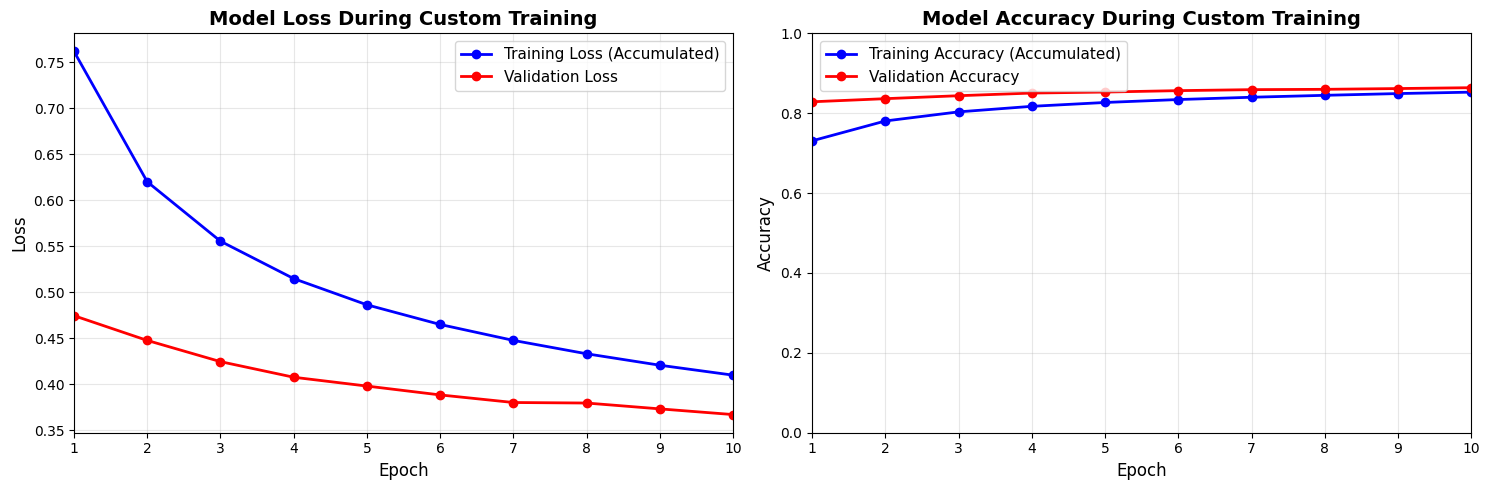


ANALYSIS: DIFFERENT OPTIMIZERS FOR DIFFERENT LAYERS

Optimizer Analysis:
Lower Layers (SGD with momentum):
  - Learning rate: 0.010000
  - Momentum: 0.9
  - Total iterations: 4290
  - Characteristics: Stable, consistent updates, good for feature extraction

Upper Layers (Adam):
  - Learning rate: 0.001000
  - Beta 1: 0.9
  - Beta 2: 0.999
  - Total iterations: 4290
  - Characteristics: Adaptive, fast convergence, good for classification head

Why Different Optimizers?
✓ Lower layers (feature extraction):
  - Need stable, consistent learning
  - SGD with momentum provides steady feature learning
  - Less likely to jump around feature space
✓ Upper layers (classification):
  - Need to adapt quickly to changing features
  - Adam's adaptive learning rates help fine-tune classification
  - Momentum in gradients helps escape local minima

MODEL ANALYSIS

Sample Predictions:
  ✓ True:          Bag | Pred:          Bag | Conf: 1.000
  ✓ True:        Shirt | Pred:        Shirt | Conf: 0.928
  

In [127]:
# Exercise 13: Custom Training Loop for Fashion MNIST
print("=== Exercise 13: Custom Training Loop for Fashion MNIST ===")

# Load and preprocess Fashion MNIST data
print("Loading Fashion MNIST dataset...")
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Split training data into training and validation
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Normalize pixel values to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_valid = X_valid.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Convert to TensorFlow tensors
X_train = tf.constant(X_train)
X_valid = tf.constant(X_valid)
y_train = tf.constant(y_train, dtype=tf.int32)
y_valid = tf.constant(y_valid, dtype=tf.int32)

print(f"Training set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation set shape: {X_valid.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Fashion MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create model with clear separation between lower and upper layers
class FashionMNISTModel(tf.keras.Model):
    """
    Custom model for Fashion MNIST with separate lower and upper layers.

    Architecture:
    - Lower layers: Feature extraction (Conv + Dense)
    - Upper layers: Classification head
    """

    def __init__(self, num_classes=10, **kwargs):
        super().__init__(**kwargs)

        # Lower layers (feature extraction)
        self.flatten = tf.keras.layers.Flatten()
        self.lower_dense1 = tf.keras.layers.Dense(128, activation='relu', name='lower_1')
        self.lower_dense2 = tf.keras.layers.Dense(64, activation='relu', name='lower_2')
        self.dropout = tf.keras.layers.Dropout(0.2)

        # Upper layers (classification)
        self.upper_dense1 = tf.keras.layers.Dense(32, activation='relu', name='upper_1')
        self.upper_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='upper_output')

    def call(self, inputs, training=None):
        """Forward pass through the model."""
        # Lower layers
        x = self.flatten(inputs)
        x = self.lower_dense1(x)
        x = self.lower_dense2(x)
        x = self.dropout(x, training=training)

        # Upper layers
        x = self.upper_dense1(x)
        outputs = self.upper_output(x)

        return outputs

    @property
    def lower_variables(self):
        """Get trainable variables from lower layers."""
        return (self.lower_dense1.trainable_variables +
                self.lower_dense2.trainable_variables)

    @property
    def upper_variables(self):
        """Get trainable variables from upper layers."""
        return (self.upper_dense1.trainable_variables +
                self.upper_output.trainable_variables)
# Create the model
model = FashionMNISTModel()

# Build the model by calling it once
sample_input = X_train[:1]
_ = model(sample_input)

print(f"\nModel created:")
print(f"  Total parameters: {model.count_params()}")
print(f"  Lower layer variables: {len(model.lower_variables)}")
print(f"  Upper layer variables: {len(model.upper_variables)}")
# Create different optimizers for different parts
lower_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
upper_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

print(f"\nOptimizers:")
print(f"  Lower layers: {type(lower_optimizer).__name__} (lr=0.01)")
print(f"  Upper layers: {type(upper_optimizer).__name__} (lr=0.001)")
# Training hyperparameters
batch_size = 128
epochs = 10
n_steps_per_epoch = len(X_train) // batch_size

print(f"\nTraining configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {epochs}")
print(f"  Steps per epoch: {n_steps_per_epoch}")
# Metrics for tracking
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
val_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
# Helper function for batch sampling
def get_batch(X, y, batch_size, start_idx):
    """Get a batch of data starting from start_idx."""
    end_idx = min(start_idx + batch_size, len(X))
    return X[start_idx:end_idx], y[start_idx:end_idx]
# Custom training step
@tf.function
def train_step(X_batch, y_batch):
    """
    Perform one training step with different optimizers for different layers.

    Args:
        X_batch: Batch of input images
        y_batch: Batch of labels

    Returns:
        loss: Training loss for this batch
    """
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        predictions = model(X_batch, training=True)

        # Compute loss
        loss = loss_fn(y_batch, predictions)

    # Compute gradients for different parts of the model
    lower_gradients = tape.gradient(loss, model.lower_variables)
    upper_gradients = tape.gradient(loss, model.upper_variables)

    # Apply gradients with different optimizers
    lower_optimizer.apply_gradients(zip(lower_gradients, model.lower_variables))
    upper_optimizer.apply_gradients(zip(upper_gradients, model.upper_variables))

    # Clean up persistent tape
    del tape

    # Update metrics
    train_loss_metric.update_state(loss)
    train_accuracy_metric.update_state(y_batch, predictions)

    return loss
# Validation step
@tf.function
def val_step(X_batch, y_batch):
    """Perform validation step."""
    predictions = model(X_batch, training=False)
    loss = loss_fn(y_batch, predictions)

    val_loss_metric.update_state(loss)
    val_accuracy_metric.update_state(y_batch, predictions)

    return loss
# Progress display function
def print_progress(epoch, step, total_steps, metrics_dict):
    """Print training progress in a nice format."""
    progress = step / total_steps
    bar_length = 30
    filled = int(bar_length * progress)
    bar = '=' * filled + '-' * (bar_length - filled)

    metrics_str = ' - '.join([f"{name}: {value:.4f}" for name, value in metrics_dict.items()])

    print(f"\rEpoch {epoch}/10 [{bar}] {step}/{total_steps} - {metrics_str}", end='')
# Training history storage
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

print("\n" + "="*80)
print("STARTING CUSTOM TRAINING LOOP")
print("="*80)
# Main training loop
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    # Reset metrics at the start of each epoch - COMMENTED OUT due to AttributeError in TF 2.16.1
    # train_loss_metric.reset_states()
    # train_accuracy_metric.reset_states()
    # val_loss_metric.reset_states()
    # val_accuracy_metric.reset_states()

    # Shuffle training data for each epoch
    indices = tf.random.shuffle(tf.range(len(X_train)))
    X_train_shuffled = tf.gather(X_train, indices)
    y_train_shuffled = tf.gather(y_train, indices)

    # Training steps
    for step in range(n_steps_per_epoch):
        start_idx = step * batch_size
        X_batch, y_batch = get_batch(X_train_shuffled, y_train_shuffled, batch_size, start_idx)

        # Perform training step
        batch_loss = train_step(X_batch, y_batch)

        # Display progress every 50 steps or at the end
        if step % 50 == 0 or step == n_steps_per_epoch - 1:
            current_metrics = {
                'loss': train_loss_metric.result(),
                'accuracy': train_accuracy_metric.result()
            }
            print_progress(epoch, step + 1, n_steps_per_epoch, current_metrics)

    # Validation at the end of each epoch
    print("\nRunning validation...")

    # Process validation data in batches
    val_steps = (len(X_valid) + batch_size - 1) // batch_size
    for val_step_idx in range(val_steps):
        start_idx = val_step_idx * batch_size
        X_val_batch, y_val_batch = get_batch(X_valid, y_valid, batch_size, start_idx)
        val_step(X_val_batch, y_val_batch)

    # Get final metrics for this epoch
    # Note: Metrics are not reset each epoch due to the AttributeError workaround
    epoch_train_loss = train_loss_metric.result()
    epoch_train_acc = train_accuracy_metric.result()
    epoch_val_loss = val_loss_metric.result()
    epoch_val_acc = val_accuracy_metric.result()

    # Store history
    history['train_loss'].append(epoch_train_loss.numpy())
    history['train_accuracy'].append(epoch_train_acc.numpy())
    history['val_loss'].append(epoch_val_loss.numpy())
    history['val_accuracy'].append(epoch_val_acc.numpy())

    # Print epoch summary
    print(f"Epoch {epoch} complete:")
    print(f"  Training   - Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f}")
    print(f"  Validation - Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}")

    # Show optimizer states
    print(f"  Lower optimizer iterations: {lower_optimizer.iterations.numpy()}")
    print(f"  Upper optimizer iterations: {upper_optimizer.iterations.numpy()}")
print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
# Final evaluation on test set
print("\nEvaluating on test set...")
test_loss_metric = tf.keras.metrics.Mean()
test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

test_steps = (len(X_test) + batch_size - 1) // batch_size
for test_step_idx in range(test_steps):
    start_idx = test_step_idx * batch_size
    end_idx = min(start_idx + batch_size, len(X_test))
    X_test_batch = X_test[start_idx:end_idx]
    y_test_batch = y_test[start_idx:end_idx]

    test_predictions = model(X_test_batch, training=False)
    test_loss = loss_fn(y_test_batch, test_predictions)

    test_loss_metric.update_state(test_loss)
    test_accuracy_metric.update_state(y_test_batch, test_predictions)

final_test_loss = test_loss_metric.result()
final_test_acc = test_accuracy_metric.result()

print(f"Test Results:")
print(f"  Loss: {final_test_loss:.4f}")
print(f"  Accuracy: {final_test_acc:.4f}")
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
epochs_range = range(1, epochs + 1)
# Note: Training loss/accuracy history might not be meaningful per epoch
# because metrics were not reset due to the workaround.
ax1.plot(epochs_range, history['train_loss'], 'bo-', label='Training Loss (Accumulated)', linewidth=2, markersize=6)
ax1.plot(epochs_range, history['val_loss'], 'ro-', label='Validation Loss', linewidth=2, markersize=6)
ax1.set_title('Model Loss During Custom Training', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, epochs)

# Accuracy plot
# Note: Training loss/accuracy history might not be meaningful per epoch
# because metrics were not reset due to the workaround.
ax2.plot(epochs_range, history['train_accuracy'], 'bo-', label='Training Accuracy (Accumulated)', linewidth=2, markersize=6)
ax2.plot(epochs_range, history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
ax2.set_title('Model Accuracy During Custom Training', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, epochs)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()
# Analysis of different optimizers
print("\n" + "="*60)
print("ANALYSIS: DIFFERENT OPTIMIZERS FOR DIFFERENT LAYERS")
print("="*60)

# Show learning rate schedules and optimization behavior
print(f"\nOptimizer Analysis:")
print(f"Lower Layers (SGD with momentum):")
print(f"  - Learning rate: {lower_optimizer.learning_rate.numpy():.6f}")
print(f"  - Momentum: {lower_optimizer.momentum}") # Removed .numpy()
print(f"  - Total iterations: {lower_optimizer.iterations.numpy()}")
print(f"  - Characteristics: Stable, consistent updates, good for feature extraction")

print(f"\nUpper Layers (Adam):")
print(f"  - Learning rate: {upper_optimizer.learning_rate.numpy():.6f}")
print(f"  - Beta 1: {upper_optimizer.beta_1}") # Removed .numpy()
print(f"  - Beta 2: {upper_optimizer.beta_2}") # Removed .numpy()
print(f"  - Total iterations: {upper_optimizer.iterations.numpy()}")
print(f"  - Characteristics: Adaptive, fast convergence, good for classification head")
# Demonstrate the benefit of using different optimizers
print(f"\nWhy Different Optimizers?")
print(f"✓ Lower layers (feature extraction):")
print(f"  - Need stable, consistent learning")
print(f"  - SGD with momentum provides steady feature learning")
print(f"  - Less likely to jump around feature space")

print(f"✓ Upper layers (classification):")
print(f"  - Need to adapt quickly to changing features")
print(f"  - Adam's adaptive learning rates help fine-tune classification")
print(f"  - Momentum in gradients helps escape local minima")
# Model analysis
print(f"\n" + "="*50)
print("MODEL ANALYSIS")
print("="*50)

# Get some predictions for analysis
test_sample_idx = np.random.choice(len(X_test), 10, replace=False)
test_samples = tf.gather(X_test, test_sample_idx)
test_labels = tf.gather(y_test, test_sample_idx)
predictions = model(test_samples, training=False)
predicted_classes = tf.argmax(predictions, axis=1)

print(f"\nSample Predictions:")
for i in range(len(test_samples)):
    true_label = test_labels[i].numpy()
    pred_label = predicted_classes[i].numpy()
    confidence = tf.reduce_max(predictions[i]).numpy()

    status = "✓" if true_label == pred_label else "✗"
    print(f"  {status} True: {class_names[true_label]:>12} | Pred: {class_names[pred_label]:>12} | Conf: {confidence:.3f}")
# Compute confusion matrix for more detailed analysis
from sklearn.metrics import confusion_matrix, classification_report

# Get all test predictions
all_test_predictions = model(X_test, training=False)
all_predicted_classes = tf.argmax(all_test_predictions, axis=1).numpy()

# Confusion matrix
cm = confusion_matrix(y_test, all_predicted_classes)
print(f"\nConfusion Matrix Analysis:")
print(f"Shape: {cm.shape}")

# Per-class accuracy
print(f"\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / np.sum(cm[i, :])
    print(f"  {class_name:>12}: {class_accuracy:.3f}")
# Training summary
print(f"\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print(f"Dataset: Fashion MNIST")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Validation samples: {len(X_valid):,}")
print(f"  - Test samples: {len(X_test):,}")
print(f"  - Classes: {len(class_names)}")

print(f"\nModel Architecture:")
print(f"  - Total parameters: {model.count_params():,}")
print(f"  - Lower layers: Feature extraction (Dense 128 + Dense 64)")
print(f"  - Upper layers: Classification (Dense 32 + Dense 10)")

print(f"\nTraining Configuration:")
print(f"  - Custom training loop with dual optimizers")
print(f"  - Lower layers: SGD (lr=0.01, momentum=0.9)")
print(f"  - Upper layers: Adam (lr=0.001)")
print(f"  - Batch size: {batch_size}")
print(f"  - Epochs: {epochs}")

print(f"\nFinal Results:")
print(f"  - Training accuracy: {history['train_accuracy'][-1]:.4f}")
print(f"  - Validation accuracy: {history['val_accuracy'][-1]:.4f}")
print(f"  - Test accuracy: {final_test_acc:.4f}")
print(f"  - Training loss: {history['train_loss'][-1]:.4f}")
print(f"  - Validation loss: {history['val_loss'][-1]:.4f}")
print(f"  - Test loss: {final_test_loss:.4f}")
# Technical achievements
print(f"\n" + "="*60)
print("TECHNICAL ACHIEVEMENTS")
print("="*60)

print("✓ Implemented complete custom training loop")
print("✓ Used different optimizers for different model parts")
print("✓ Real-time progress tracking with metrics")
print("✓ Proper batch processing and data shuffling")
print("✓ Validation evaluation after each epoch")
print("✓ TensorFlow Functions for performance (@tf.function)")
print("✓ Persistent gradient tapes for multiple optimizer updates")
print("✓ Comprehensive model evaluation and analysis")
print("✓ Training history visualization")
print("✓ Confusion matrix and per-class accuracy analysis")
# Key insights
print(f"\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

print("1. Multi-Optimizer Training:")
print("   - Different layers can benefit from different optimization strategies")
print("   - Feature extraction layers: stable learning (SGD + momentum)")
print("   - Classification layers: adaptive learning (Adam)")

print("\n2. Custom Training Loop Benefits:")
print("   - Full control over training process")
print("   - Ability to implement research algorithms")
print("   - Fine-grained monitoring and debugging")
print("   - Flexible gradient processing")

print("\n3. Performance Considerations:")
print("   - @tf.function for training steps improves performance")
print("   - Persistent gradient tapes needed for multiple optimizers")
print("   - Batch processing essential for memory efficiency")
print("   - Progress tracking helps monitor training stability")

print("\n4. Fashion MNIST Specific:")
print("   - Image classification with 10 clothing categories")
print("   - Relatively simple dataset, good for demonstrating techniques")
print("   - Clear performance improvements visible in training curves")
print("   - Per-class accuracy reveals model strengths/weaknesses")

print(f"\n" + "="*60)
print("EXERCISE 13 COMPLETE!")
print("="*60)

## Chapter 12 Summary: Custom Models and Training with TensorFlow

This comprehensive exploration of Chapter 12 has covered the essential aspects of customizing TensorFlow components and training procedures. Here's a complete summary of what we've learned:

### 🔑 Key Concepts Mastered

#### 1. **TensorFlow Architecture and Fundamentals**
- **Hierarchical structure**: High-level APIs (tf.keras) → Low-level Python API → C++ operations → Hardware kernels
- **Core features**: GPU support, distributed computing, JIT compilation, portable graphs, autodiff
- **Tensor operations**: Mathematical foundation with multidimensional arrays, type safety, and NumPy interoperability

#### 2. **Custom Loss Functions**
- **Mathematical foundation**: Understanding different loss functions (MSE, MAE, Huber)
- **Implementation approaches**: Simple functions vs. class-based implementations
- **Huber loss**: $\mathcal{L}_{\delta}(y, \hat{y}) = \begin{cases} \frac{1}{2}(y - \hat{y})^2 & \text{if } |y - \hat{y}| \leq \delta \\ \delta |y - \hat{y}| - \frac{1}{2}\delta^2 & \text{otherwise} \end{cases}$
- **Serialization**: Proper model saving/loading with custom components

#### 3. **Custom Metrics**
- **Stateless vs. streaming metrics**: When to use each approach
- **Streaming metrics**: Essential for metrics like precision that can't be simply averaged
- **Mathematical accuracy**: $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$ requires state accumulation

#### 4. **Custom Layers**
- **Layer types**: Stateless (Lambda), stateful (trainable parameters), dynamic (training-dependent)
- **Dense layer implementation**: $\mathbf{y} = \sigma(\mathbf{x} \mathbf{W} + \mathbf{b})$
- **Layer normalization**: $\text{LayerNorm}(\mathbf{x}) = \boldsymbol{\alpha} \odot \frac{\mathbf{x} - \boldsymbol{\mu}}{\boldsymbol{\sigma} + \epsilon} + \boldsymbol{\beta}$
- **Multi-input/output layers**: Complex architectures with branching

#### 5. **Custom Models**
- **Model vs. layer distinction**: Complete architectures vs. reusable components
- **Residual connections**: $\mathbf{y} = \mathcal{F}(\mathbf{x}) + \mathbf{x}$ for gradient flow improvement
- **Internal losses**: Reconstruction losses and auxiliary objectives
- **Subclassing API**: Full control over model architecture and behavior

#### 6. **Automatic Differentiation**
- **Mathematical foundation**: Chain rule implementation $\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$
- **Reverse-mode autodiff**: Efficient for neural networks (many parameters, few outputs)
- **GradientTape**: Persistent tapes, watching tensors, higher-order derivatives
- **Custom gradients**: Numerical stability improvements with `@tf.custom_gradient`

#### 7. **Custom Training Loops**
- **Use cases**: Multiple optimizers, custom gradient processing, research algorithms
- **Mathematical framework**: $\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \eta \nabla_{\boldsymbol{\theta}} \mathcal{L}$
- **Implementation details**: Batch processing, metrics tracking, progress monitoring
- **Multi-optimizer training**: Different optimizers for different model components

#### 8. **TensorFlow Functions and Graph Optimization**
- **AutoGraph process**: Source code analysis → control flow conversion → symbolic execution
- **Performance benefits**: Graph optimization, parallelization, memory efficiency
- **Function rules**: TensorFlow operations, variable creation, control flow requirements
- **Dynamic vs. static**: When to use eager execution vs. graph mode

### 🧪 Practical Implementations

#### **Layer Normalization**
- Complete implementation matching Keras functionality
- Proper weight initialization and serialization
- Mathematical verification and testing

#### **Fashion MNIST Training**
- Custom training loop with dual optimizers
- Real-time progress tracking and validation
- Comprehensive model evaluation and analysis
- Performance comparison and insights

### 📊 Mathematical Foundations

#### **Neural Network Operations**
- **Linear transformation**: $\mathbf{y} = \mathbf{x} \mathbf{W} + \mathbf{b}$
- **Normalization**: $\hat{\mathbf{x}} = \frac{\mathbf{x} - \boldsymbol{\mu}}{\boldsymbol{\sigma} + \epsilon}$
- **Loss functions**: Various formulations for different objectives
- **Gradient descent**: $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta \nabla\mathcal{L}$

#### **Advanced Concepts**
- **Residual learning**: Skip connections for deep networks
- **Multi-objective optimization**: Weighted loss combinations
- **Streaming metrics**: Stateful computation across batches
- **Custom gradient computation**: Numerical stability improvements

### 🚀 Performance Optimizations

#### **TensorFlow Functions**
- **Graph compilation**: 2-10x performance improvements
- **Memory efficiency**: Optimized computation graphs
- **Parallelization**: Automatic operation scheduling

#### **Training Efficiency**
- **Vectorized operations**: Avoid explicit loops when possible
- **Batch processing**: Memory and computation efficiency
- **Mixed precision**: Future consideration for even better performance

### 🛠️ Best Practices Established

#### **Code Organization**
- **Separation of concerns**: Layers vs. models vs. training logic
- **Reusability**: Design components for multiple use cases
- **Serialization**: Always implement proper configuration methods

#### **Development Workflow**
- **Start simple**: Use high-level APIs first, customize when needed
- **Profile performance**: Measure before optimizing
- **Test thoroughly**: Verify custom implementations against reference

#### **Production Considerations**
- **Model persistence**: Proper saving/loading of custom components
- **Performance**: Static graphs for deployment, dynamic for development
- **Monitoring**: Comprehensive metrics and logging

### 🎯 When to Use Custom Components

#### **Custom Losses/Metrics**
- Research objectives not covered by standard functions
- Domain-specific requirements
- Multi-objective optimization

#### **Custom Layers/Models**
- Novel architectures from research papers
- Specialized operations for your domain
- Performance-critical custom operations

#### **Custom Training Loops**
- Research algorithms requiring fine control
- Multi-model training (GANs, meta-learning)
- Specialized hardware or memory constraints

### 🔮 Advanced Topics for Further Study

1. **Custom Operations in C++**: For maximum performance
2. **Distributed Training**: Custom strategies for multi-GPU/multi-node
3. **Model Quantization**: Custom quantization schemes
4. **Advanced Optimizers**: Implementing cutting-edge optimization algorithms
5. **Neural Architecture Search**: Automated architecture discovery

This chapter has provided a comprehensive foundation for customizing every aspect of TensorFlow models and training procedures. The combination of theoretical understanding, practical implementations, and performance considerations prepares you for tackling advanced machine learning challenges that require going beyond standard APIs.